# Prep. Works

In [ ]:
# Reset variables if needed
%reset -f

In [ ]:
# Import needed libraries
import gdown
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer, TargetEncoder, StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, recall_score, confusion_matrix, ConfusionMatrixDisplay
!pip install optuna
import optuna
!pip install dalex
import dalex as dx
import warnings
warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for dalex: filename=dalex-1.7.1-py3-none-any.whl size=1042797 sha256=eb054ee9986eda741539592fdf1536d3ce7c5bb553db5db65ab17040e785d462
  Stored in directory: /root/.cache/pip/wheels/fe/c2/41/63e006b3312a4e17299bed5f83d985dea872368f9ab16bb20f
Successfully built dalex


In [ ]:
# Import shared dataset from google drive
id = '1Fi2YCd3iftS3DUBqw4giPp9ah6zhg38j'
url = f'https://drive.google.com/uc?id={id}'
gdown.download(url, 'Lending_Club_Loan_Default_Dataset.csv', quiet=True)
df = pd.read_csv('Lending_Club_Loan_Default_Dataset.csv')

In [ ]:
# Check information of the imported .csv file
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1347681 entries, 0 to 1347680
Data columns (total 15 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   id                1347681 non-null  int64  
 1   issue_d           1347681 non-null  object 
 2   revenue           1347681 non-null  float64
 3   dti_n             1347681 non-null  float64
 4   loan_amnt         1347681 non-null  int64  
 5   fico_n            1347681 non-null  float64
 6   experience_c      1347681 non-null  int64  
 7   emp_length        1347681 non-null  object 
 8   purpose           1347681 non-null  object 
 9   home_ownership_n  1347681 non-null  object 
 10  addr_state        1347681 non-null  object 
 11  zip_code          1347680 non-null  object 
 12  Default           1347681 non-null  int64  
 13  title             1331024 non-null  object 
 14  desc              119099 non-null   object 
dtypes: float64(3), int64(4), object(8)
memory usage: 

In [ ]:
# Examine imported .csv file
df.head()

,id,issue_d,revenue,dti_n,loan_amnt,fico_n,experience_c,emp_length,purpose,home_ownership_n,addr_state,zip_code,Default,title,desc
0,68407277,Dec-2015,55000.0,5.91,3600,677.0,1,10+ years,debt_consolidation,MORTGAGE,PA,190xx,0,Debt consolidation,NaN
1,68355089,Dec-2015,65000.0,16.06,24700,717.0,1,10+ years,small_business,MORTGAGE,SD,577xx,0,Business,NaN
2,68341763,Dec-2015,71000.0,13.85,20000,697.0,1,10+ years,home_improvement,MORTGAGE,IL,605xx,0,NaN,NaN
3,68476807,Dec-2015,104433.0,25.37,10400,697.0,1,3 years,major_purchase,MORTGAGE,PA,174xx,0,Major purchase,NaN
4,68426831,Dec-2015,34000.0,10.20,11950,692.0,1,4 years,debt_consolidation,RENT,GA,300xx,0,Debt consolidation,NaN


**Variable Descriptions:**

**Target Variable Description:**

- 'Default' : Binary variable categorizing fully paid loans and defaulted loans (0 = fully paid, 1 = defaulted loans)

**Explanatory Variable Descriptions:**

- 'id' : Unique identifier column to ensure the uniqueness of each loan
- 'issue_d' : Month and year in which the loan was approved
- 'revenue' : Borrower's self-declared annual income during registration
- 'dti_n' : Debt-to-income ratio, indebtedness ratio for obligations excluding mortgage for the whole group of borrowers (primary and co-borrowers) (monthly debt payments / co-borrowers total income in percentage terms)
- 'loan_amnt' : Amount of credit requested by the borrower
- 'fico_n' : FICO score, a credit scoring system by the Fair Isaac Corporation ranging between 300 (poorest credit) to 850 (best credit)
- 'experience_c' : Binary variable that indicates whether the borrower is new to the entity (Lending Club)
- 'emp_length' : Categorical variable with the employment length of the borrower (includes the no information category)
- 'purpose' : Credit purpose category for the loan requested
- 'home_ownership_n' : Homeownership status provided by the borrower during the registration process
- 'addr_state' : Borrower's residence state (United States)
- 'zip_code' : Zip code of the borrower's residence
- 'title' : Title of the credit request description provided by the borrower
- 'desc' : Description of the credit request provided by the borrower

**Business End Goals:**

- Building a classification machine learning model to predict the probability of default based on the borrowers' characteristics
- To be used in advanced prior to handing out loans to borrowers, potentially useful in determining borrowers' trustworthiness ratings ─ thus giving lenders more information to work with in deciding whether or not to invest in any particular borrower
- Recall would be used as the primary evaluation metric of choice due to the need to minimize false negatives (defaultees labeled as non-defaultees)

# Data Preprocessing (Cleaning and Manipulation)

## Duplicated Values Check

In [ ]:
# Check for duplicates in df['id']
df['id'].duplicated().sum()

0

In [ ]:
# Dropping columns that won't be analyzed further
df = df.drop(columns='id') # Dropped since there is no need anymore for a unique identifier
df = df.drop(columns='issue_d') # Dropped due to the cross-sectional nature of the project
df = df.drop(columns='zip_code') # Dropped due to a higher level of geographic analysis provided by the column 'addr_state'
df = df.drop(columns='title') # Dropped due to redundancy as loan purposes have already been categorized within the 'purpose' column
df = df.drop(columns='desc') # Dropped due to the lack of need for textual analysis on default prediction

In [ ]:
# Checking information after duplicated values check and irrelevant column droppings
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1347681 entries, 0 to 1347680
Data columns (total 10 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   revenue           1347681 non-null  float64
 1   dti_n             1347681 non-null  float64
 2   loan_amnt         1347681 non-null  int64  
 3   fico_n            1347681 non-null  float64
 4   experience_c      1347681 non-null  int64  
 5   emp_length        1347681 non-null  object 
 6   purpose           1347681 non-null  object 
 7   home_ownership_n  1347681 non-null  object 
 8   addr_state        1347681 non-null  object 
 9   Default           1347681 non-null  int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 102.8+ MB


## Train-Test Split

In [ ]:
# Train-test split without assigning features/target to avoid leakage, 20% test size
train, test = train_test_split(df, test_size=0.2, random_state=42)

## Missingness Handling

In [ ]:
# Checking for missingness in training set
train.isna().sum()

,0
revenue,0
dti_n,0
loan_amnt,0
fico_n,0
experience_c,0
emp_length,0
purpose,0
home_ownership_n,0
addr_state,0
Default,0


In [ ]:
# Checking for missingness in test set
test.isna().sum()

,0
revenue,0
dti_n,0
loan_amnt,0
fico_n,0
experience_c,0
emp_length,0
purpose,0
home_ownership_n,0
addr_state,0
Default,0


### Saving Non-Transformed (Intepretable) EDA Set

In [ ]:
# Making an interpretable copy of the train set to be used for EDA before transformations and encoding
train_eda = train.copy()

## Outlier Identification and Handling

In [ ]:
# Checking information in preparation for numerical variables identification using training set
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1078144 entries, 166636 to 121958
Data columns (total 10 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   revenue           1078144 non-null  float64
 1   dti_n             1078144 non-null  float64
 2   loan_amnt         1078144 non-null  int64  
 3   fico_n            1078144 non-null  float64
 4   experience_c      1078144 non-null  int64  
 5   emp_length        1078144 non-null  object 
 6   purpose           1078144 non-null  object 
 7   home_ownership_n  1078144 non-null  object 
 8   addr_state        1078144 non-null  object 
 9   Default           1078144 non-null  int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 90.5+ MB


**Notes:**

- Outlier identification and handling would only be done on numerical data (continuous and discrete), the process won't be done on categorical data (ordinal and nominal)
- Outlier identification would be done using multiple box plots for each series alongside numeric values for the skewness and kurtosis of the series
- In the event of the existence of significant outliers (|skew| > 1 and/or |kurtosis| > 2), then the series would be power transformed and standardized using Yeo-Johnson transformation which would work even in the existence of zero and negative values
- Yeo-Johnson's lambdas fit that were applied to the training set would also be applied to the test set to avoid leakage
- Prior to Yeo-Johnson a filtering process would also be done in order to remove data points that were assessed to be anomalies

**Numerical Variables Identified:**

- 'revenue'
- 'dti_n'
- 'loan_amnt'
- 'fico_n'

### Outlier Identification

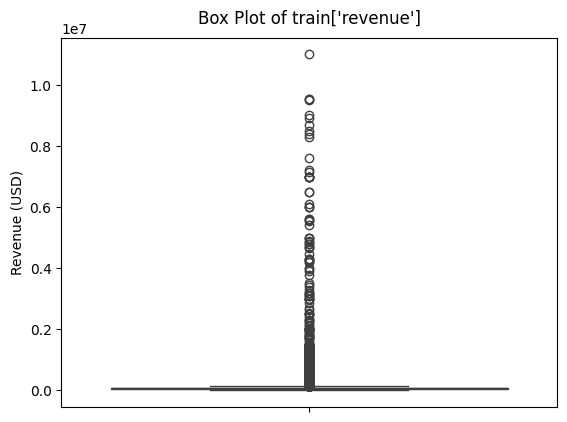


Skewness: 43.508438829741806
Kurtosis: 4439.17611338719

High skewness indicates a need for transformation, high kurtosis indicates a need for filtering


In [ ]:
# train['revenue'] outlier identification
plt.figure(figsize=(6.4,4.8))
sns.boxplot(train['revenue'])
plt.title("Box Plot of train['revenue']", pad=10)
plt.ylabel('Revenue (USD)')
plt.show()

print()
print(f"Skewness: {train['revenue'].skew()}")
print(f"Kurtosis: {train['revenue'].kurtosis()}")

print()
print('High skewness indicates a need for transformation, high kurtosis indicates a need for filtering')

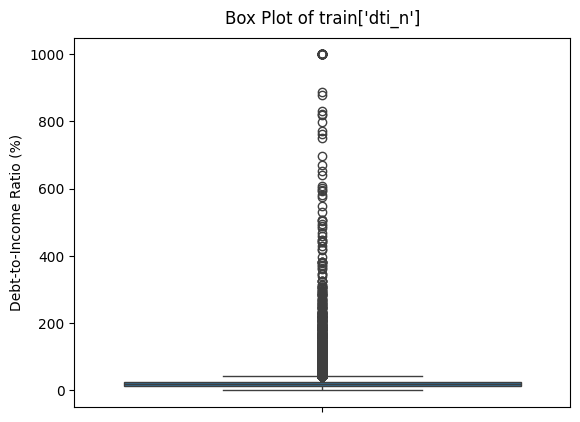


Skewness: 27.31619078361953
Kurtosis: 2133.401901448026

High skewness indicates a need for transformation, high kurtosis indicates a need for filtering


In [ ]:
# train['dti_n'] outlier identification
plt.figure(figsize=(6.4,4.8))
sns.boxplot(train['dti_n'])
plt.title("Box Plot of train['dti_n']", pad=10)
plt.ylabel('Debt-to-Income Ratio (%)')
plt.show()

print()
print(f"Skewness: {train['dti_n'].skew()}")
print(f"Kurtosis: {train['dti_n'].kurtosis()}")

print()
print('High skewness indicates a need for transformation, high kurtosis indicates a need for filtering')

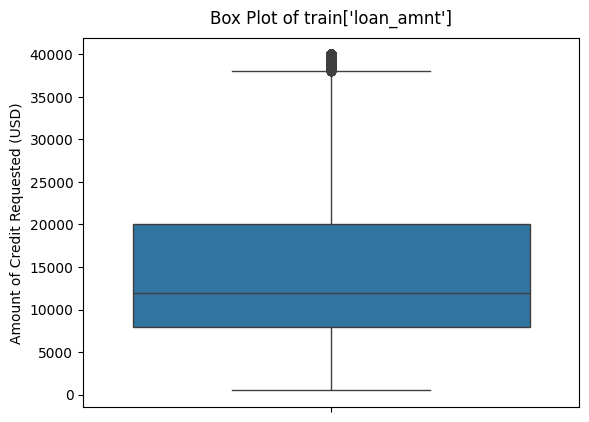


Skewness: 0.7830070044827062
Kurtosis: -0.08220776286225595

There are minimal indications of outliers in the series, no need to transform nor filter


In [ ]:
# df['loan_amnt'] outlier identification
plt.figure(figsize=(6.4,4.8))
sns.boxplot(train['loan_amnt'])
plt.title("Box Plot of train['loan_amnt']", pad=10)
plt.ylabel('Amount of Credit Requested (USD)')
plt.show()

print()
print(f"Skewness: {train['loan_amnt'].skew()}")
print(f"Kurtosis: {train['loan_amnt'].kurtosis()}")

print()
print('There are minimal indications of outliers in the series, no need to transform nor filter')

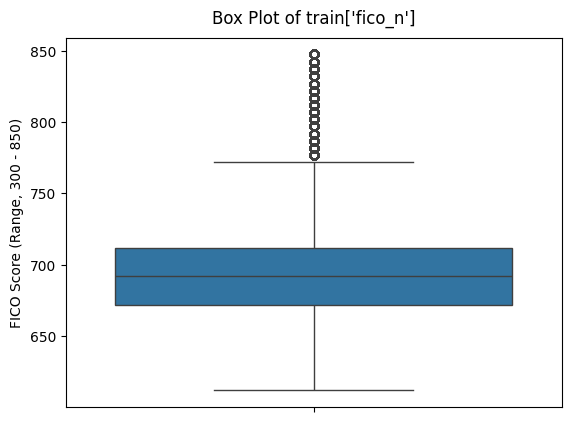


Skewness: 1.285555233270401
Kurtosis: 1.6672765141978068

High skewness indicates a need for transformation, low kurtosis indicates no need for filtering


In [ ]:
# df['fico_n'] outlier identification
plt.figure(figsize=(6.4,4.8))
sns.boxplot(train['fico_n'])
plt.title("Box Plot of train['fico_n']", pad=10)
plt.ylabel('FICO Score (Range, 300 - 850)')
plt.show()

print()
print(f"Skewness: {train['fico_n'].skew()}")
print(f"Kurtosis: {train['fico_n'].kurtosis()}")

print()
print('High skewness indicates a need for transformation, low kurtosis indicates no need for filtering')

### Outlier Handling

**Notes:**

- Out of the 4 series, 3 require either Yeo-Johnson transformation or extreme values filtering
- There are 2 series that require extreme values filtering, which include 'revenue' and 'dti_n'
- These 2 series have a |kurtosis| of > 2, therefore due to the cutoff rule setup previously they are the right candidates for filtering
- There are 3 series that require Yeo-Johnson transformation, which include 'revenue', 'dti_n', and 'fico_n'
- These 3 series have a |skew| of > 1, therefore due to the cutoff rule setup previously they are the right candidates for transformation
- Extreme values filtering rules would also be applied on both the train_eda set and the test set to ensure consistency in data preprocessing, ensuring an easier to understand EDA process
- Yeo-Johnson's lambdas fit would only be applied on the training set in order to avoid leakage to the test set
- Test set's series would only be transformed through the previously learned (lambda) parameters during training
- Distribution characteristics would be rechecked after each one of the outlier handling processes, after filtering and after transformation

In [ ]:
# Checking pre-filtered and pre-transformed training set shape
train.shape

(1078144, 10)

In [ ]:
display(train['revenue'].sort_values(ascending = False).head())
print()
display(train['dti_n'].sort_values(ascending = False).head())

# The variable 'revenue' would have a cutoff value of 1000000 USD, this is due to the unrealistic expectation that high earners won't be granted loans from banks
# The variable 'dti_n' would have a cutoff value of 50%, this is due to the general unwillingness of lenders to lend money to borrowers with such a high DTI value

,revenue
401581,10999200.0
574869,9550000.0
974244,9522972.0
203890,9500000.0
35666,9000000.0


,dti_n
1316284,999.0
1206646,999.0
993339,999.0
1261608,999.0
895940,999.0


In [ ]:
# Filtering for unusual 'revenue' and 'dti_n' from the train set
train = train[(train['revenue'] <= 1000000) & (train['dti_n'] <= 50)]

# Filtering for unusual 'revenue' and 'dti_n' from the test set
test = test[(test['revenue'] <= 1000000) & (test['dti_n'] <= 50)]

# Filtering for unusual 'revenue' and dti_n' from the train_eda set
train_eda = train_eda[(train_eda['revenue'] <= 1000000) & (train_eda['dti_n'] <= 50)]

In [ ]:
# Post-filtering skewness and kurtosis check
numericals = ['revenue','dti_n']

print("Skewness:")
display(train[numericals].skew())
print()
print("Kurtosis:")
display(train[numericals].kurtosis())

# The variable 'dti_n' is approximately normal after removing extreme outliers, therefore there is no longer a need for Yeo-Johnson transformation

Skewness:


,0
revenue,4.124425
dti_n,0.266667



Kurtosis:


,0
revenue,37.652570
dti_n,-0.422756


In [ ]:
# Initialize power transformer
transformer = PowerTransformer(method='yeo-johnson')

numericals = ['revenue','fico_n']

train[numericals] = transformer.fit_transform(train[numericals])
test[numericals] = transformer.transform(test[numericals])

In [ ]:
# Post-transformation skewness and kurtosis check
numericals = ['revenue','dti_n','loan_amnt','fico_n']

print("Skewness:")
display(train[numericals].skew())
print()
print("Kurtosis:")
display(train[numericals].kurtosis())

# Outlier handling methods:
# Extreme values filtering = 'revenue' and 'dti_n'
# Yeo-Johnson transformation = 'revenue' and 'fico_n'
# No handling = 'loan_amnt'

# Now all 4 numerical series are approximately normal at a |skewness| of < 1 and a |kurtosis| of < 2

Skewness:


,0
revenue,-0.009539
dti_n,0.266667
loan_amnt,0.783422
fico_n,0.000000



Kurtosis:


,0
revenue,0.699893
dti_n,-0.422756
loan_amnt,-0.080427
fico_n,0.000000


In [ ]:
# Checking filtered and transformed training set shape
train.shape

(1075694, 10)

**Note:**

- The series' skewness and kurtosis have been dramatically reduced with minimal data loss (2450 rows removed or 0.23% of the original 1078144 rows)

## Categorical Encoding

### Categorical Encoding (Training Set)

In [ ]:
# Examining information of training set in order to determine categorical variables to be encoded
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1075694 entries, 166636 to 121958
Data columns (total 10 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   revenue           1075694 non-null  float64
 1   dti_n             1075694 non-null  float64
 2   loan_amnt         1075694 non-null  int64  
 3   fico_n            1075694 non-null  float64
 4   experience_c      1075694 non-null  int64  
 5   emp_length        1075694 non-null  object 
 6   purpose           1075694 non-null  object 
 7   home_ownership_n  1075694 non-null  object 
 8   addr_state        1075694 non-null  object 
 9   Default           1075694 non-null  int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 90.3+ MB


In [ ]:
# Preparing a categorical encoding set for non-numeric variables
categorical_encoding_set_train = train[['emp_length','purpose','home_ownership_n','addr_state']].copy()
categorical_encoding_set_train.head()

,emp_length,purpose,home_ownership_n,addr_state
166636,7 years,credit_card,RENT,CA
517738,6 years,home_improvement,MORTGAGE,CT
836919,5 years,credit_card,RENT,IL
900068,< 1 year,debt_consolidation,MORTGAGE,MA
836523,10+ years,debt_consolidation,MORTGAGE,CA


In [ ]:
# Examine unique categories of each categorical variable, determining encoding type to be used
for col in categorical_encoding_set_train.columns:
  print(categorical_encoding_set_train[col].value_counts())
  print()

emp_length
10+ years    353785
2 years       97332
< 1 year      86155
3 years       86124
1 year        70926
5 years       67422
4 years       64702
NI            61916
6 years       50072
8 years       48740
7 years       47638
9 years       40882
Name: count, dtype: int64

purpose
debt_consolidation    623522
credit_card           235693
home_improvement       70065
other                  62674
major_purchase         23594
medical                12525
small_business         12326
car                    11723
moving                  7597
vacation                7233
house                   5775
wedding                 1869
renewable_energy         763
educational              335
Name: count, dtype: int64

home_ownership_n
MORTGAGE    531656
RENT        427845
OWN         115784
OTHER          409
Name: count, dtype: int64

addr_state
CA    157012
NY     88133
TX     87996
FL     76154
IL     41544
NJ     38932
PA     36440
OH     35247
GA     34621
VA     30257
NC     30128
MI     

**Decisions:**

- 'emp_length' = Ordinal encoding, it is assumed that people who have worked longer would have more earnings power thus having a higher capacity to repay their debts
- 'purpose' = Smoothed target encoding, no meaningful order/ranking is assumed and there are more than 5 unique elements in the series which would make one hot encoding unfeasible
- 'home_ownership_n' = One hot encoding, initially assumed to be ordinal but there are also conflicting evidence showing that renting could in fact be better (financially) than owning thus indicating that more financially savvy people might in fact rent rather than own
- 'addr_state' = Smoothed target encoding, no meaningful order/ranking is assumed and there are more than 5 unique elements in the series which would make one hot encoding unfeasible

In [ ]:
# 'emp_length' categorical variable ordinal encoding
emp_length_map = {
    '10+ years': 11,
    '9 years': 10,
    '8 years': 9,
    '7 years': 8,
    '6 years': 7,
    '5 years': 6,
    '4 years': 5,
    '3 years': 4,
    '2 years': 3,
    '1 year': 2,
    '< 1 year': 1,
    'NI': 0
}

categorical_encoding_set_train['emp_length'] = categorical_encoding_set_train['emp_length'].map(emp_length_map)

In [ ]:
# 'purpose' categorical variable smoothed target encoding
t_encoder_1 = TargetEncoder(smooth='auto', target_type='binary')
categorical_encoding_set_train['purpose'] = t_encoder_1.fit_transform(categorical_encoding_set_train[['purpose']], train[['Default']])

In [ ]:
# 'home_ownership_n' categorical variable one hot encoding
categorical_encoding_set_train = pd.get_dummies(categorical_encoding_set_train, columns=['home_ownership_n'], drop_first=False)
categorical_encoding_set_train = categorical_encoding_set_train.drop(columns=['home_ownership_n_OTHER'])
categorical_encoding_set_train['home_ownership_n_OWN'] = categorical_encoding_set_train['home_ownership_n_OWN'].map({True: 1, False: 0})
categorical_encoding_set_train['home_ownership_n_MORTGAGE'] = categorical_encoding_set_train['home_ownership_n_MORTGAGE'].map({True: 1, False: 0})
categorical_encoding_set_train['home_ownership_n_RENT'] = categorical_encoding_set_train['home_ownership_n_RENT'].map({True: 1, False: 0})

In [ ]:
# 'addr_state' categorical variable smoothed target encoding
t_encoder_2 = TargetEncoder(smooth='auto', target_type='binary')
categorical_encoding_set_train['addr_state'] = t_encoder_2.fit_transform(categorical_encoding_set_train[['addr_state']], train[['Default']])

In [ ]:
# Examining the encoded training set
categorical_encoding_set_train.head()

,emp_length,purpose,addr_state,home_ownership_n_MORTGAGE,home_ownership_n_OWN,home_ownership_n_RENT
166636,8,0.169792,0.196444,0,0,1
517738,7,0.176595,0.172375,1,0,0
836919,6,0.170005,0.181325,0,0,1
900068,1,0.211972,0.185578,1,0,0
836523,11,0.211949,0.196038,1,0,0


In [ ]:
# Drop the original categorical columns from the training set
train = train.drop([
    'emp_length',
    'purpose',
    'home_ownership_n',
    'addr_state'], axis=1)

# Concatenate the encoded variables with the original training set
train = pd.concat([train, categorical_encoding_set_train], axis=1)

# Examine the concatenated variables on the training set
train.head()

,revenue,dti_n,loan_amnt,fico_n,experience_c,Default,emp_length,purpose,addr_state,home_ownership_n_MORTGAGE,home_ownership_n_OWN,home_ownership_n_RENT
166636,0.181494,8.71,8000,2.031708e-14,1,0,8,0.169792,0.196444,0,0,1
517738,1.725371,11.29,32000,-1.110223e-14,1,0,7,0.176595,0.172375,1,0,0
836919,0.129137,12.65,7700,-1.110223e-14,1,1,6,0.170005,0.181325,0,0,1
900068,0.129137,21.26,15000,-8.520962e-15,1,0,1,0.211972,0.185578,1,0,0
836523,0.281666,14.05,11000,2.969847e-15,1,0,11,0.211949,0.196038,1,0,0


### Categorical Encoding (Testing Set)

In [ ]:
# Preparing a categorical encoding set for non-numeric variables
categorical_encoding_set_test = test[['emp_length','purpose','home_ownership_n','addr_state']].copy()
categorical_encoding_set_test.head()

,emp_length,purpose,home_ownership_n,addr_state
486099,10+ years,debt_consolidation,MORTGAGE,OH
367342,3 years,debt_consolidation,MORTGAGE,LA
234143,1 year,debt_consolidation,OWN,TX
1239475,10+ years,debt_consolidation,RENT,CA
1081157,10+ years,debt_consolidation,MORTGAGE,AL


In [ ]:
# 'emp_length' categorical variable ordinal encoding
emp_length_map = {
    '10+ years': 11,
    '9 years': 10,
    '8 years': 9,
    '7 years': 8,
    '6 years': 7,
    '5 years': 6,
    '4 years': 5,
    '3 years': 4,
    '2 years': 3,
    '1 year': 2,
    '< 1 year': 1,
    'NI': 0
}

categorical_encoding_set_test['emp_length'] = categorical_encoding_set_test['emp_length'].map(emp_length_map)

In [ ]:
# 'purpose' categorical variable smoothed target encoding
categorical_encoding_set_test['purpose'] = t_encoder_1.transform(categorical_encoding_set_test[['purpose']])

In [ ]:
# 'home_ownership_n' categorical variable one hot encoding
categorical_encoding_set_test = pd.get_dummies(categorical_encoding_set_test, columns=['home_ownership_n'], drop_first=False)
categorical_encoding_set_test = categorical_encoding_set_test.drop(columns=['home_ownership_n_OTHER'])
categorical_encoding_set_test['home_ownership_n_OWN'] = categorical_encoding_set_test['home_ownership_n_OWN'].map({True: 1, False: 0})
categorical_encoding_set_test['home_ownership_n_MORTGAGE'] = categorical_encoding_set_test['home_ownership_n_MORTGAGE'].map({True: 1, False: 0})
categorical_encoding_set_test['home_ownership_n_RENT'] = categorical_encoding_set_test['home_ownership_n_RENT'].map({True: 1, False: 0})

In [ ]:
# 'addr_state' categorical variable smoothed target encoding
categorical_encoding_set_test['addr_state'] = t_encoder_2.transform(categorical_encoding_set_test[['addr_state']])

In [ ]:
# Drop the original categorical columns from the testing set
test = test.drop([
    'emp_length',
    'purpose',
    'home_ownership_n',
    'addr_state'], axis=1)

# Concatenate the encoded variables with the original testing set
test = pd.concat([test, categorical_encoding_set_test], axis=1)

# Examine the concatenated variables on the testing set
test.head()

,revenue,dti_n,loan_amnt,fico_n,experience_c,Default,emp_length,purpose,addr_state,home_ownership_n_MORTGAGE,home_ownership_n_OWN,home_ownership_n_RENT
486099,-0.159361,13.22,5000,-1.657008e-14,1,0,11,0.211819,0.204641,1,0,0
367342,0.257164,11.78,30000,-1.657008e-14,1,1,4,0.211819,0.230362,1,0,0
234143,0.612425,27.98,25000,1.243450e-14,1,0,2,0.211819,0.199248,0,1,0
1239475,0.671504,29.44,22825,-1.657008e-14,1,1,11,0.211819,0.196501,0,0,1
1081157,-0.159361,18.66,26500,6.966649e-15,1,0,11,0.211819,0.236958,1,0,0


## Feature/Target Split, Standardization, and Post-Processing Undersampling

In [ ]:
# Splitting preprocessed data to feature and target sets (for both training/test sets)
feature_train = train.drop(columns='Default')
target_train = train[['Default']]
feature_test = test.drop(columns='Default')
target_test = test[['Default']]

# Applying standard scaler to 'loan_amnt' and 'dti_n' as they are the only numerical variables left that have yet to be standardized
scaler = StandardScaler()
feature_train[['loan_amnt']] = scaler.fit_transform(feature_train[['loan_amnt']])
feature_test[['loan_amnt']] = scaler.transform(feature_test[['loan_amnt']])
feature_train[['dti_n']] = scaler.fit_transform(feature_train[['dti_n']])
feature_test[['dti_n']] = scaler.transform(feature_test[['dti_n']])

In [ ]:
# Examine target balance of the training set, determining whether or not undersampling is needed
target_train['Default'].value_counts(normalize=True)

,proportion
Default,
0,0.800193
1,0.199807


In [ ]:
# Undersampling to handle imbalance data and improve model performance, on train set only to avoid leakage
undersampler = RandomUnderSampler(random_state=42)
feature_train_balanced, target_train_balanced = undersampler.fit_resample(feature_train, target_train)

## Multicollinearity Study

**Note:**

- In this multicollinearity study, numerical variables are classified as variables that are either continuous or discrete in nature, excluding encoded categorical variables such as ordinal or nominal data

**Numerical Variables Identified:**

- 'revenue'
- 'dti_n'
- 'loan_amnt'
- 'fico_n'

**Target Variable:**

- 'Default'

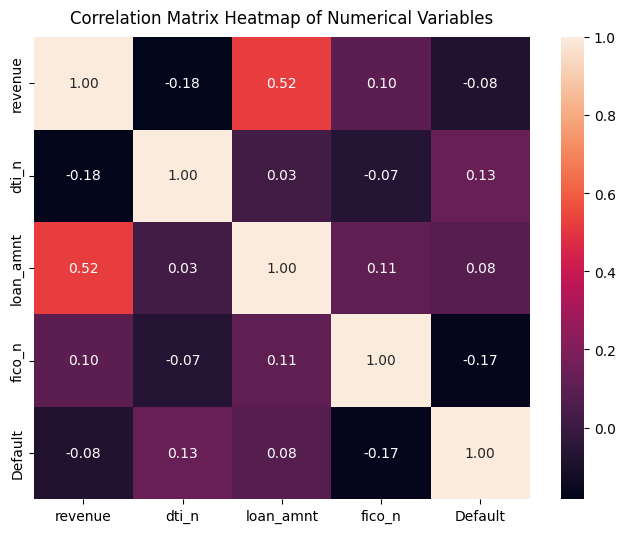

In [ ]:
# Examining correlation matrix heatmap for potential multicollinearity issues
numericals = pd.concat([feature_train_balanced, target_train_balanced], axis=1)
numericals = numericals[['revenue','dti_n','loan_amnt','fico_n','Default']]
correlation = numericals.corr()
plt.figure(figsize=(8,6))
sns.heatmap(correlation, annot=True, fmt='.2f')
plt.title("Correlation Matrix Heatmap of Numerical Variables", pad=10)
plt.show()

**Notes:**

- In this study we would use an |r| cutoff value of 0.8, meaning that if 2 variables have an absolute correlation of at least 0.8 then said variables would further be investigated for multicollinearity
- In the plot above, there doesn't seem to be any issue of multicollinearity
- The numerical variables of the train data are found to be independent of one another, therefore to avoid leakage the same independence assumption would be held on to the test set

# Exploratory Data Analysis (EDA)

## Statistical EDA

In [ ]:
# Examining first several rows of the train EDA set used
train_eda.head()

,revenue,dti_n,loan_amnt,fico_n,experience_c,emp_length,purpose,home_ownership_n,addr_state,Default
166636,72000.0,8.71,8000,752.0,1,7 years,credit_card,RENT,CA,0
517738,170000.0,11.29,32000,672.0,1,6 years,home_improvement,MORTGAGE,CT,0
836919,70000.0,12.65,7700,672.0,1,5 years,credit_card,RENT,IL,1
900068,70000.0,21.26,15000,677.0,1,< 1 year,debt_consolidation,MORTGAGE,MA,0
836523,76000.0,14.05,11000,702.0,1,10+ years,debt_consolidation,MORTGAGE,CA,0


In [ ]:
# Examining information of the train EDA set used
train_eda.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1075694 entries, 166636 to 121958
Data columns (total 10 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   revenue           1075694 non-null  float64
 1   dti_n             1075694 non-null  float64
 2   loan_amnt         1075694 non-null  int64  
 3   fico_n            1075694 non-null  float64
 4   experience_c      1075694 non-null  int64  
 5   emp_length        1075694 non-null  object 
 6   purpose           1075694 non-null  object 
 7   home_ownership_n  1075694 non-null  object 
 8   addr_state        1075694 non-null  object 
 9   Default           1075694 non-null  int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 90.3+ MB


In [ ]:
# Transforming 'experience_c' and 'Default' to object variables, to be used for classification EDA
train_eda['experience_c'] = train_eda['experience_c'].apply(lambda x: 'Experienced' if x == 1 else 'Newcomer')
train_eda['Default'] = train_eda['Default'].apply(lambda x: 'Yes' if x == 1 else 'No')
train_eda['experience_c'] = train_eda['experience_c'].astype(object)
train_eda['Default'] = train_eda['Default'].astype(object)

In [ ]:
# Examine transformed categorical columns
train_eda[['experience_c', 'Default']].head()

,experience_c,Default
166636,Experienced,No
517738,Experienced,No
836919,Experienced,Yes
900068,Experienced,No
836523,Experienced,No


In [ ]:
# Categorizing series based on column types
categoricals = ['experience_c','emp_length','purpose','home_ownership_n','addr_state','Default']
numericals = ['revenue','dti_n','loan_amnt','fico_n']

In [ ]:
# Statistical summary for categorical columns
train_eda[categoricals].describe()

,experience_c,emp_length,purpose,home_ownership_n,addr_state,Default
count,1075694,1075694,1075694,1075694,1075694,1075694
unique,2,12,14,4,51,2
top,Experienced,10+ years,debt_consolidation,MORTGAGE,CA,No
freq,1075675,353785,623522,531656,157012,860763


**Categorical Observations:**

- The vast majority of borrowers from Lending Club are experienced borrowers, which means that they have a history of borrowing from the company even before their latest credit request
- A significant portion of people who borrowed money/requested a loan from Lending Club are seniors deep into their careers, with the most frequent occurence of borrowers with more than 10 years in employment length
- The most common purpose for credit request is debt consolidation, this means that a significant portion of debtors actually have multiple other loans outstanding that they would need to pay ─ the idea here is that the consolidation loan would be able to pay off all the other debts that they have, so in the end they would only need to pay off the consolidation loan itself instead of having to pay to multiple creditors individually
- In terms of home ownership, the majority of borrowers own a mortgage, meaning that they'd need to periodically pay money to the mortgage holder in order to retain full ownership of their house
- A small majority of borrowers reside in California ─ this could potentially point towards Lending Club's primary market of interest in California itself, or this statistics could also be misleading since California is well known to be one of the most populous states in the United States ─ nonetheless, Lending Club's got itself a big market share in that particular state
- The vast majority of borrowers are not in default, meaning that they were able to fully pay their loans without an issue

**From the observations done previously, categorically the average borrower of the company:**

- Is experienced in borrowing from Lending Club
- Is a senior well deep into their careers with more than 10 years of experience
- Is borrowing in order consolidate their other debts
- Is a mortgage owner
- Is residing in California
- Is not in default

In [ ]:
# Statistical summary for numerical columns
train_eda[numericals].describe().applymap('{:.2f}'.format)

,revenue,dti_n,loan_amnt,fico_n
count,1075694.00,1075694.00,1075694.00,1075694.00
mean,76773.56,18.13,14397.19,698.15
std,50637.92,8.46,8706.03,31.85
min,1896.00,0.00,500.00,612.00
25%,46500.00,11.80,7950.00,672.00
50%,65000.00,17.62,12000.00,692.00
75%,92000.00,24.03,20000.00,712.00
max,1000000.00,50.00,40000.00,847.50


**Numerical Observations:**

- The mean annual income of the borrowers is 76,773 USD with a standard deviation of 50,637 USD ─ where the median is 65,000 USD. This points to the existence of a positively skewed distribution whereby a small amount of borrowers make much more than the designated median thus pushing the mean upwards to the right-hand side of the distribution
- The mean debt-to-income ratio of the borrowers is 18.13% with a standard deviation of 8.46% ─ where the median is 17.62%. This points to the existence of a positively skewed distribution whereby a small amount of borrowers have much more debt burden than the designated median thus pushing the mean upwards to the right-hand side of the distribution
- The mean loan amount of the borrowers is 14,397 USD with a standard deviation of 8,706 USD ─ where the median is 12,000 USD. This points to the existence of a positively skewed distribution whereby a small amount of borrowers borrow much more money than the designated median thus pushing the mean upwards to the right-hand side of the distribution
- The mean FICO score of the borrowers is 698 with a standard deviation of 31 ─ where the median is 692. This points to a (slight) existence of a positively skewed distribution whereby a small amount of borrowers have a much higher FICO score than the designated median thus pushing the mean upwards to the right-hand side of the distribution

**From the observations done previously, numerically the average borrower of the company:**

- Has a mean annual income of 76,773 USD
- Has a debt-to-income ratio of 18.13%
- Borrows money amounting to 14,397 USD from Lending Club
- Has a FICO score of 698

**Combining both categorical and numerical observations, the most average borrower of the company:**

- Is experienced in borrowing from Lending Club
- Is a senior well deep into their careers with more than 10 years of experience
- Is borrowing in order to consolidate their other debts
- Is a mortgage owner
- Is residing in California
- Is not in default
- Has a mean annual income of 76,773 USD
- Has a debt-to-income ratio of 18.13%
- Borrows money amounting to 14,397 USD from Lending Club
- Has a FICO score of 698

In [ ]:
# Distribution summary of numerical variables
skewness = train_eda[numericals].skew()
kurtosis = train_eda[numericals].kurtosis()
distribution_summary = pd.DataFrame({'Skewness': skewness, 'Kurtosis': kurtosis})
distribution_summary

,Skewness,Kurtosis
revenue,4.124425,37.652570
dti_n,0.266667,-0.422756
loan_amnt,0.783422,-0.080427
fico_n,1.286164,1.669342


**Numerical Variables Distribution Summary Observations:**

- All variables do indeed have positive skewness, as the skewness value is above 0 for all 4 variables. However, the degrees of skewness are much different between each one of the numerical variables. Variable 'revenue' has the most positive skewness with a skew of 4.12 followed by 'fico_n' at a skewness of 1.28, 'loan_amnt' on the other hand has only minimal skewness at 0.78 and variable 'dti_n' has a skew of 0.26
- Alongside skewness, (Fisher's) kurtosis values were also checked for all 4 variables. Variable 'revenue' has the most kurtosis (fattest tail) of 37.65, 'fico_n' follows second with a kurt value of 1.66, 'loan_amnt' at -0.08 indicating very minimal thin tailedness, and 'dti_n' at -0.42 indicating minimal thin tailedness as well
- In a perfect world, a normal distribution would have a skewness and (Fisher's) kurtosis value of 0 alongside a deviation respectively at +- 1 for skewness and +- 2 for (Fisher's) kurtosis value. 2 of the 4 variables managed to fit into this perfect world normal distribution criteria which included the variables named 'dti_n' and 'loan_amnt'. The rest either have too high of a skewness or too high of a kurtosis indicating non-normality
- It should be noted however that the variables 'revenue' and 'dti_n' have been filtered for outliers before the EDA process, therefore what is observed now is only the "cleaned" version of the series' data ─ excluding extreme values that don't make business sense (such as debt-to-income of 999%, or revenue of ~ 11 million USD)

## Univariate EDA

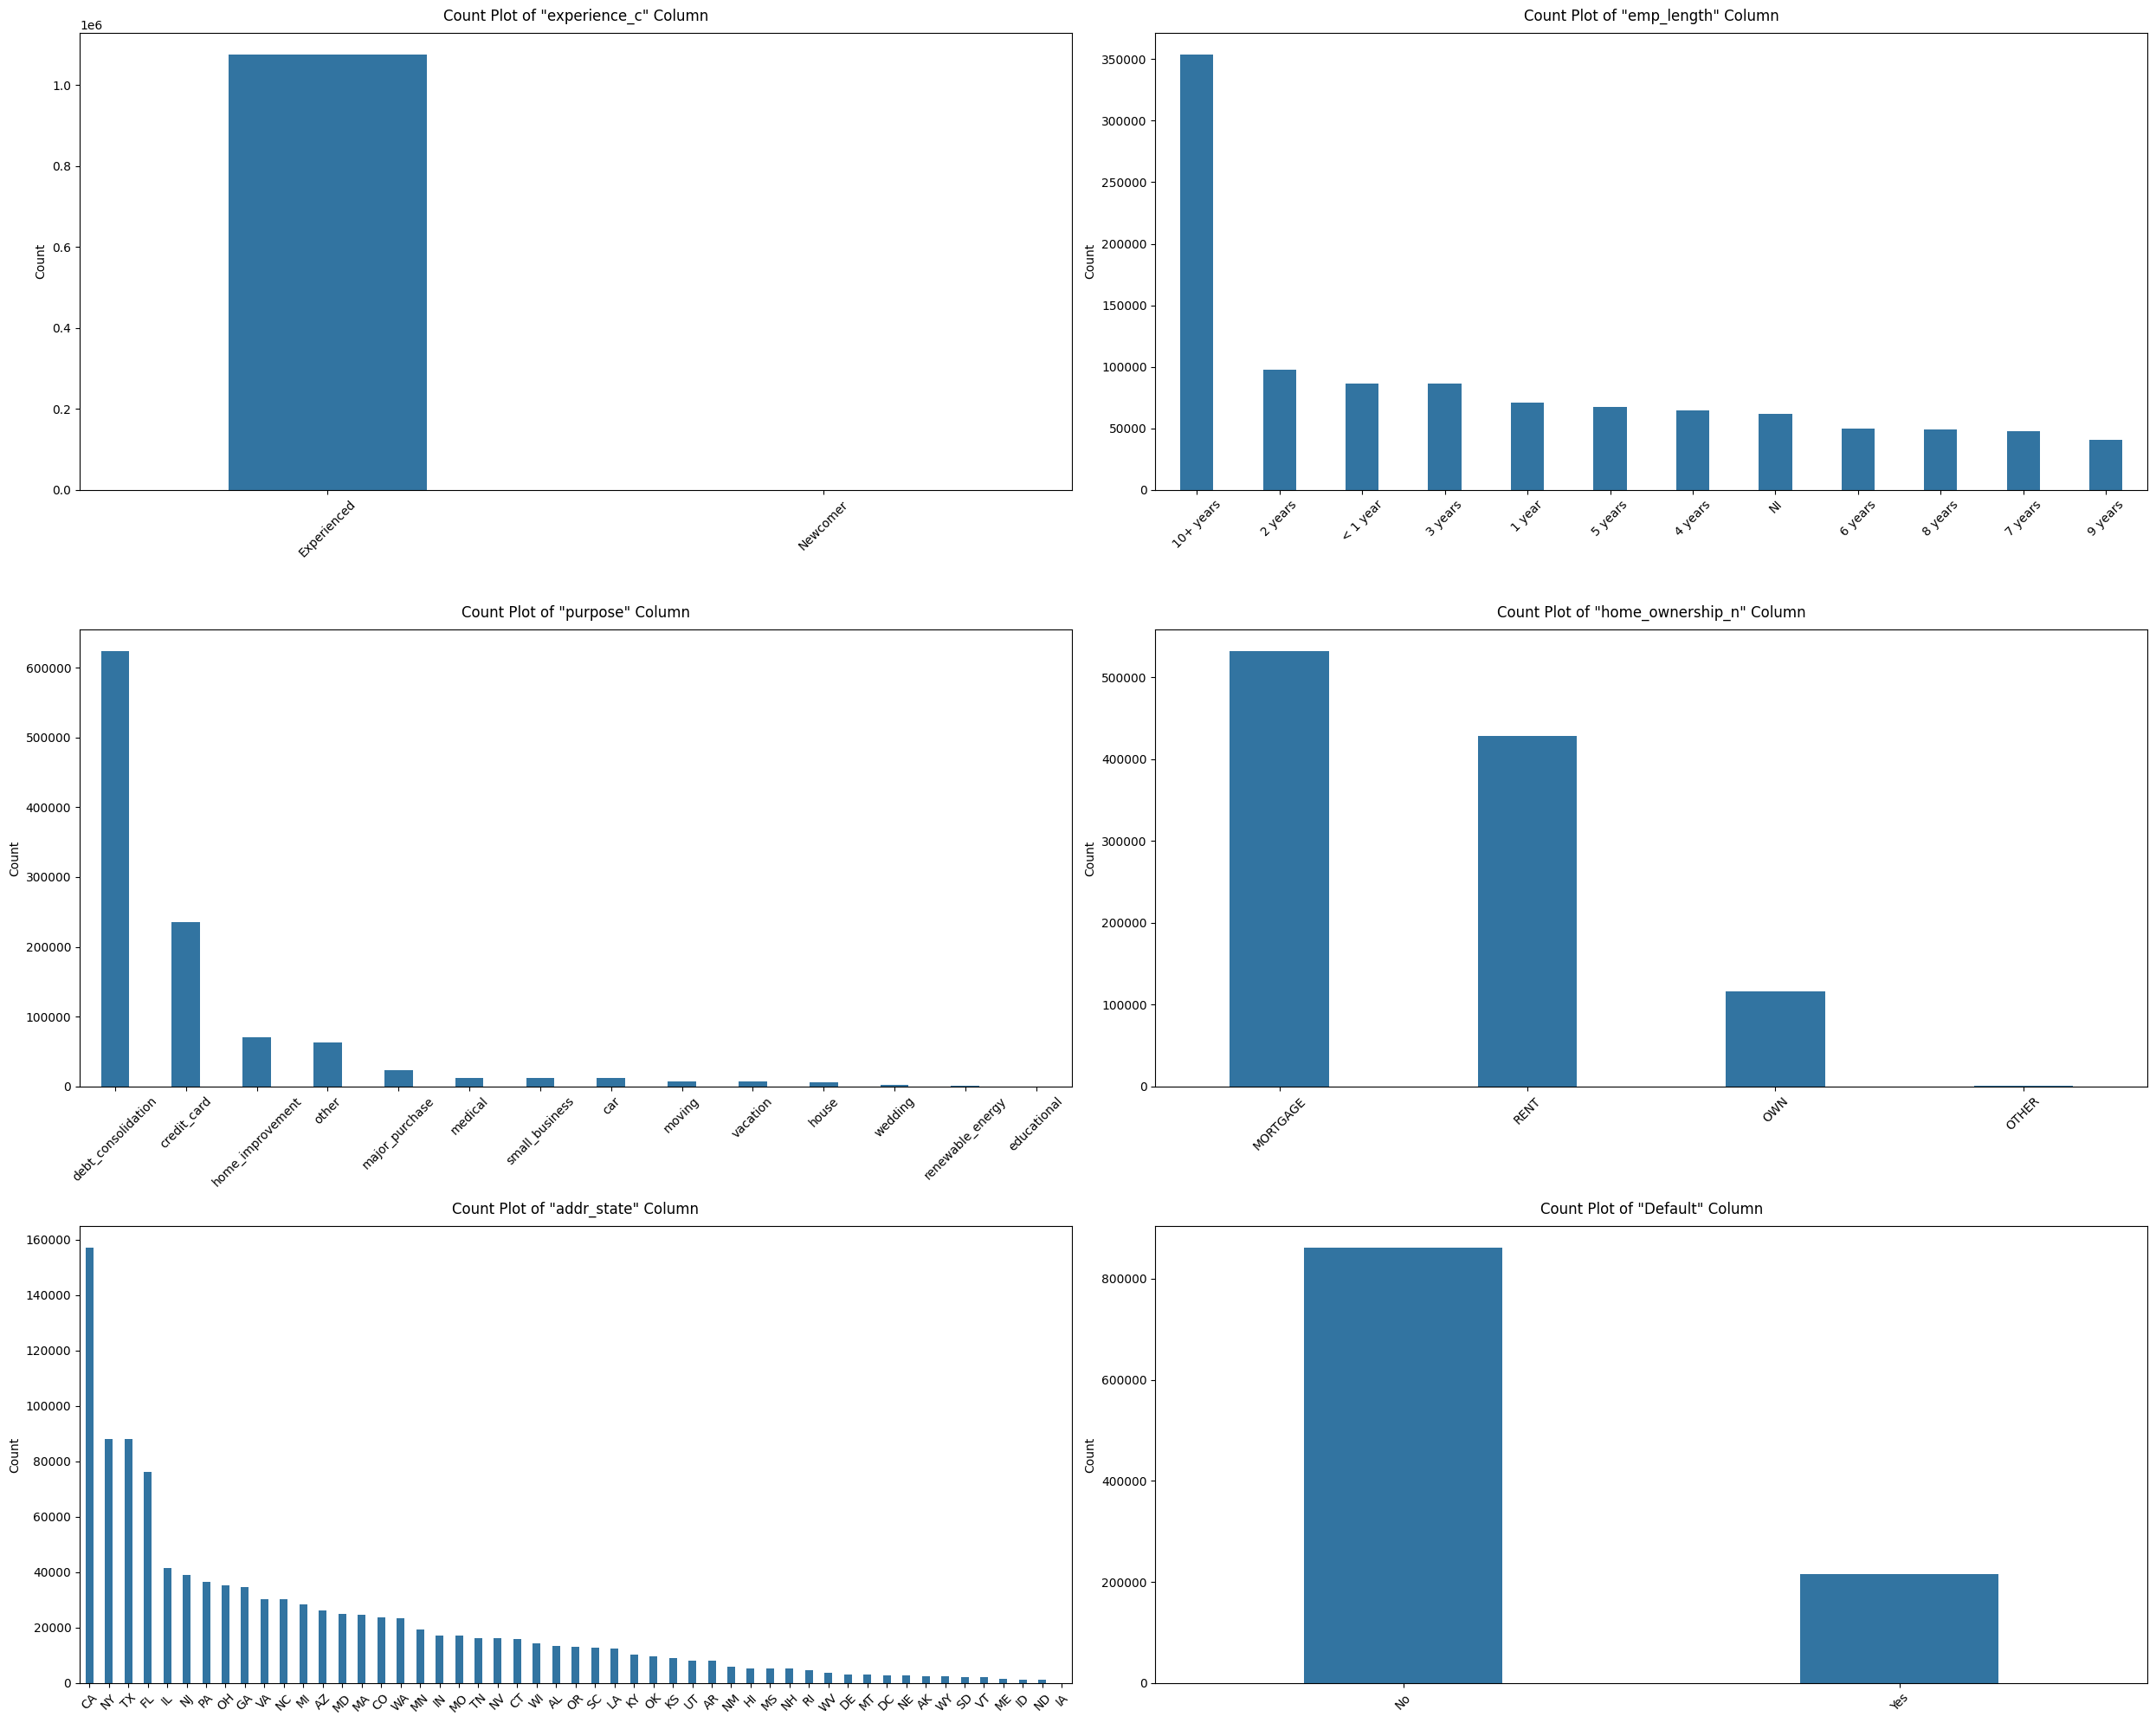

In [ ]:
# Visualizing count plots for categorical columns within the dataset
plt.figure(figsize=(25,20))
features = categoricals
plots_per_row = 2
rows = (len(features) + plots_per_row - 1) // plots_per_row
for i in range(0, len(features)):
  plt.subplot(rows, plots_per_row, i+1)
  sns.countplot(x = train_eda[features[i]], width = 0.4, order = train_eda[features[i]].value_counts(ascending=False).index)
  plt.title(f'Count Plot of "{features[i]}" Column', pad = 10)
  plt.xlabel('')
  plt.xticks(rotation = 45)
  plt.ylabel('Count')
  plt.tight_layout()

**Count Plot Observations:**

- The count plots visualized the categorical findings of the statistical summary section of the EDA done previously, making it easier to understand the degree of modality/frequency of each series on a more holistic basis
- All count plots visualized showed unimodality in terms of distributions, this means that one particular category tends to dominate the rest in the plots shown

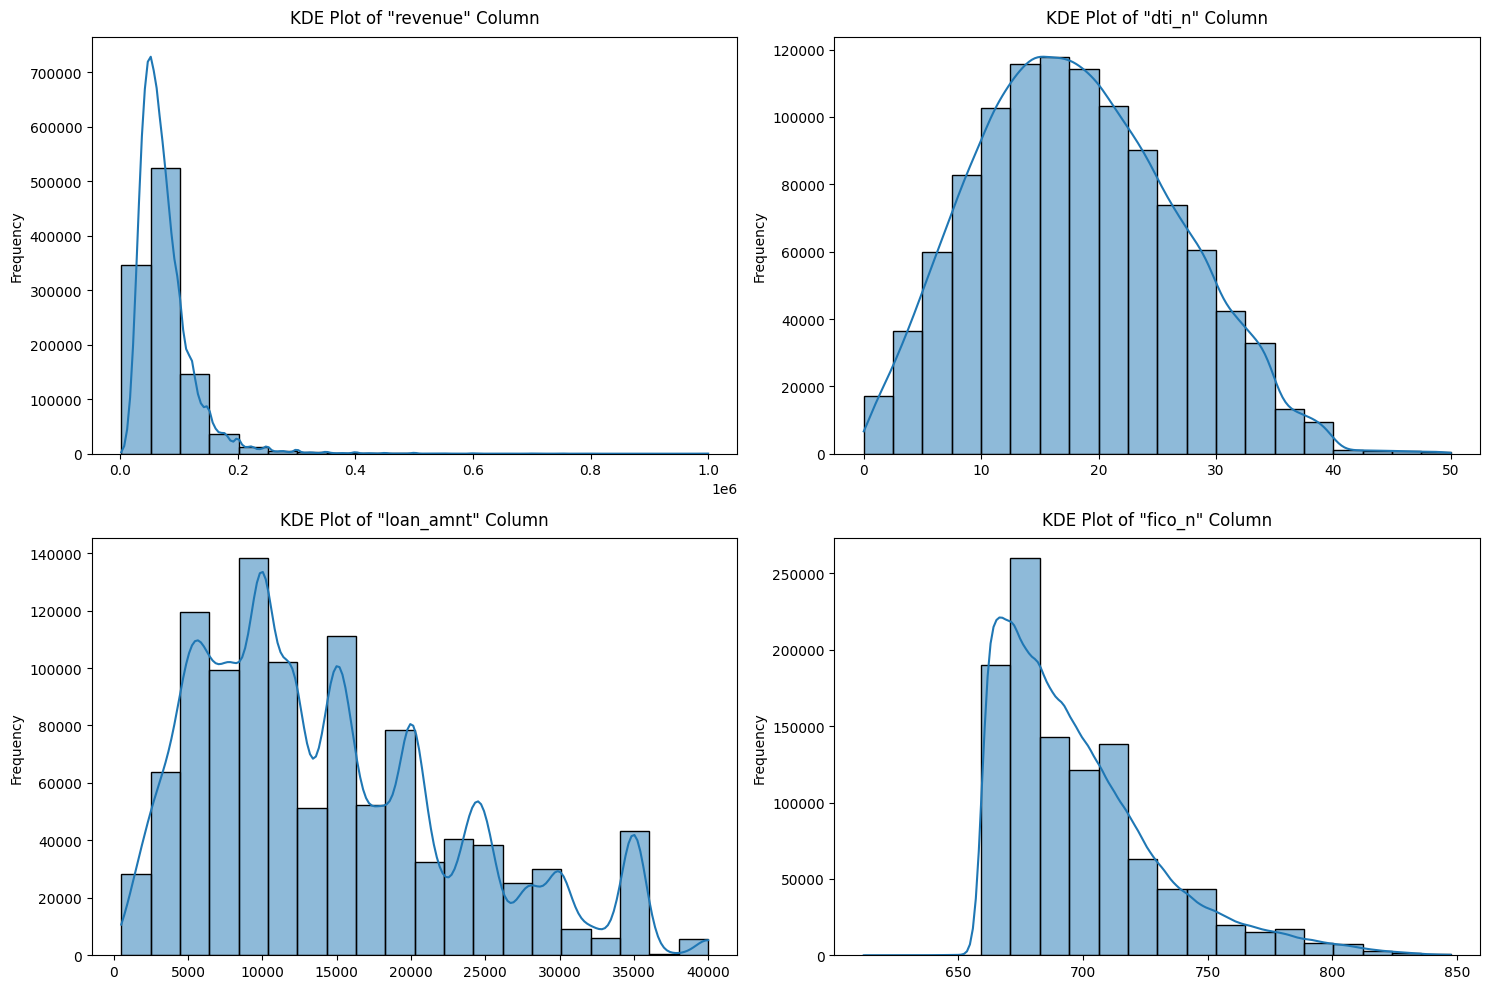

In [ ]:
# Visualizing multiple kernel density estimate (KDE) plots for numerical columns within the dataset
plt.figure(figsize=(15,10))
features = numericals
plots_per_row = 2
rows = (len(features) + plots_per_row - 1) // plots_per_row
for i in range(0, len(features)):
  plt.subplot(rows, plots_per_row, i+1)
  sns.histplot(x = train_eda[features[i]], kde = True, kde_kws={'bw_adjust': 1.5}, bins = 20)
  plt.title(f'KDE Plot of "{features[i]}" Column', pad = 10)
  plt.xlabel('')
  plt.ylabel('Frequency')
  plt.tight_layout()

**KDE Plot Observations:**

- The KDE plots visualized above reinforces the statistical summary findings of positive skewness for all of the numerical variables within the dataset, though clearly some are more skewed than others
- Heavy right tail (kurtosis) could be observed for the KDE plot of the 'revenue' column, again reinforcing the findings within the statistical summaries EDA
- Supposed "normal" KDE plots such as 'dti_n' and 'loan_amnt' still showed some degree of non-normality primarily through skewness if one were to just eyeball things

**Univariate EDA Conclusions:**

- Categorical variables within the dataset tend to have a unimodal distribution across the board, usually with the heaviest concentration on the most frequent category alongside several other smaller categories following suit
- Numerical variables within the dataset tend to have a positive skewness across the board, though some are more skewed than others alongside a heavier right tail for the column named 'revenue' ─ general characteristics of non-normal distributions

## Multivariate EDA

### Proportion Bar Plots

In [ ]:
# Normalized grouping of categorical variables in relation to default label
experience_c_group = pd.DataFrame(train_eda.groupby('experience_c')['Default'].value_counts(normalize=True).reset_index(name='Proportion (%)'))
emp_length_group = pd.DataFrame(train_eda.groupby('emp_length')['Default'].value_counts(normalize=True).reset_index(name='Proportion (%)'))
purpose_group = pd.DataFrame(train_eda.groupby('purpose')['Default'].value_counts(normalize=True).reset_index(name='Proportion (%)'))
home_ownership_n_group = pd.DataFrame(train_eda.groupby('home_ownership_n')['Default'].value_counts(normalize=True).reset_index(name='Proportion (%)'))
addr_state_group = pd.DataFrame(train_eda.groupby('addr_state')['Default'].value_counts(normalize=True).reset_index(name='Proportion (%)'))

# Sort normalized groupings by default label
experience_c_group = experience_c_group.sort_values(by=['Proportion (%)'], ascending=False)
emp_length_group = emp_length_group.sort_values(by=['Proportion (%)'], ascending=False)
purpose_group = purpose_group.sort_values(by=['Proportion (%)'], ascending=False)
home_ownership_n_group = home_ownership_n_group.sort_values(by=['Proportion (%)'], ascending=False)
addr_state_group = addr_state_group.sort_values(by=['Proportion (%)'], ascending=False)

In [ ]:
# Store all the normalized groupings into a single tuple variable
hodgepodge = experience_c_group, emp_length_group, purpose_group, home_ownership_n_group, addr_state_group

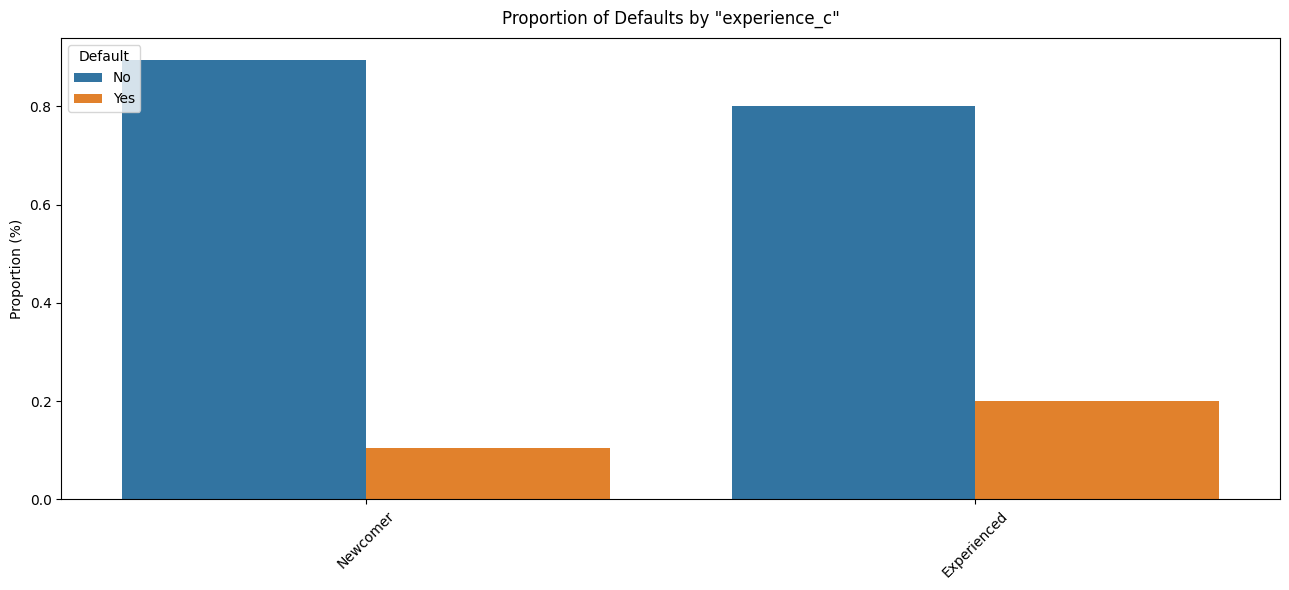

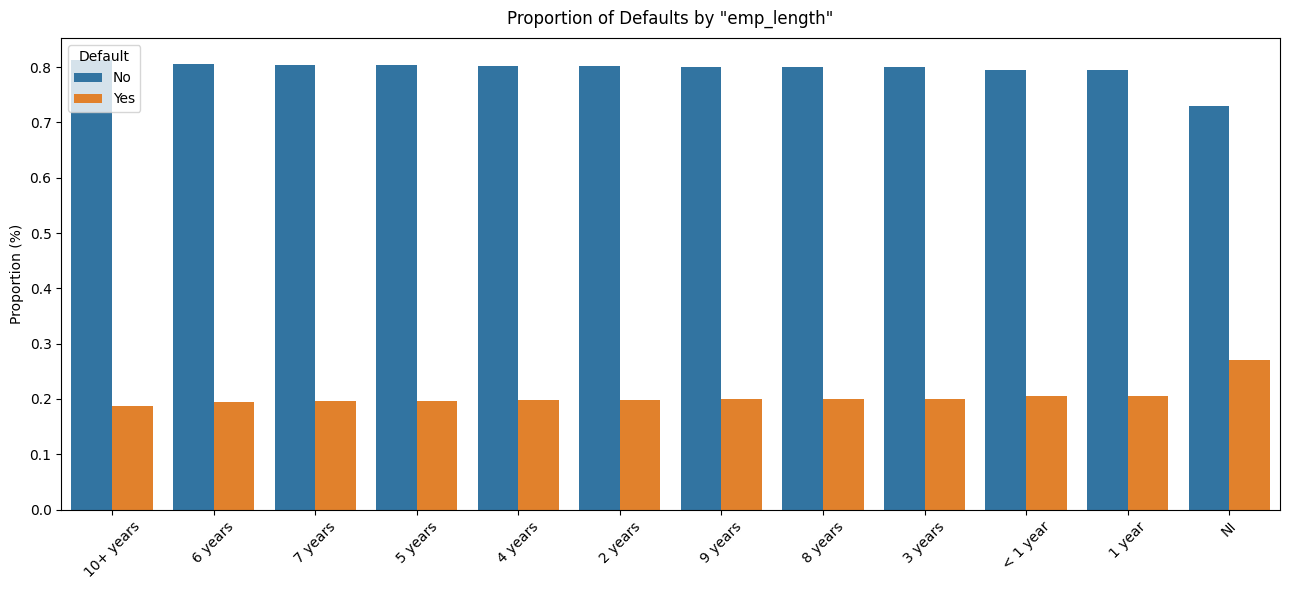

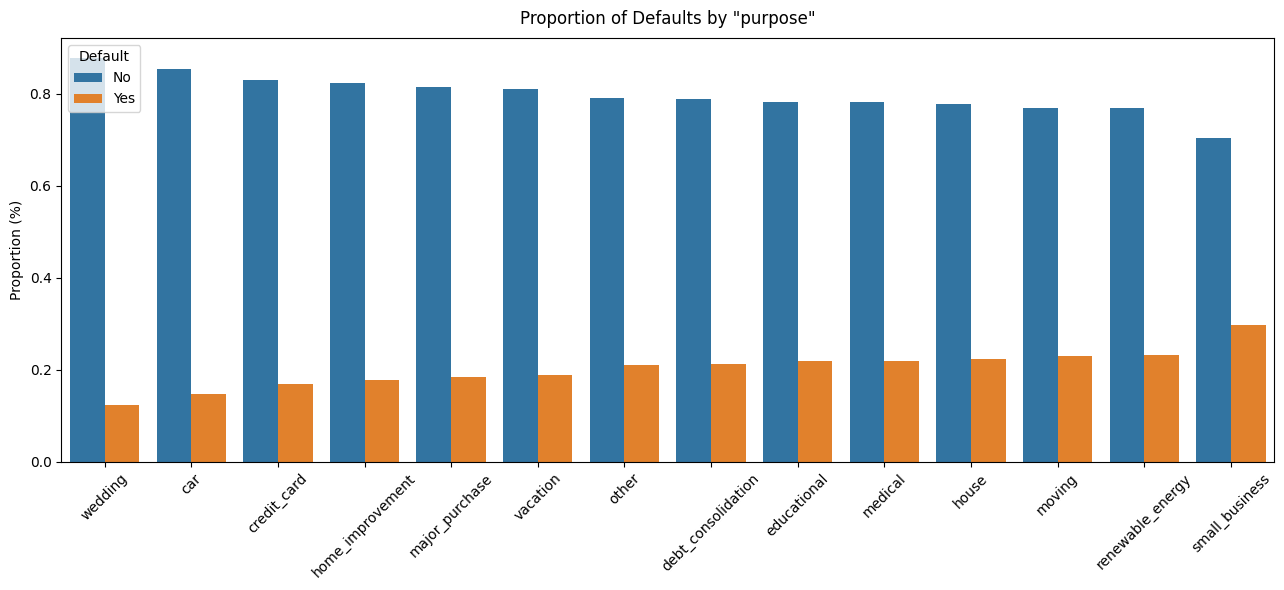

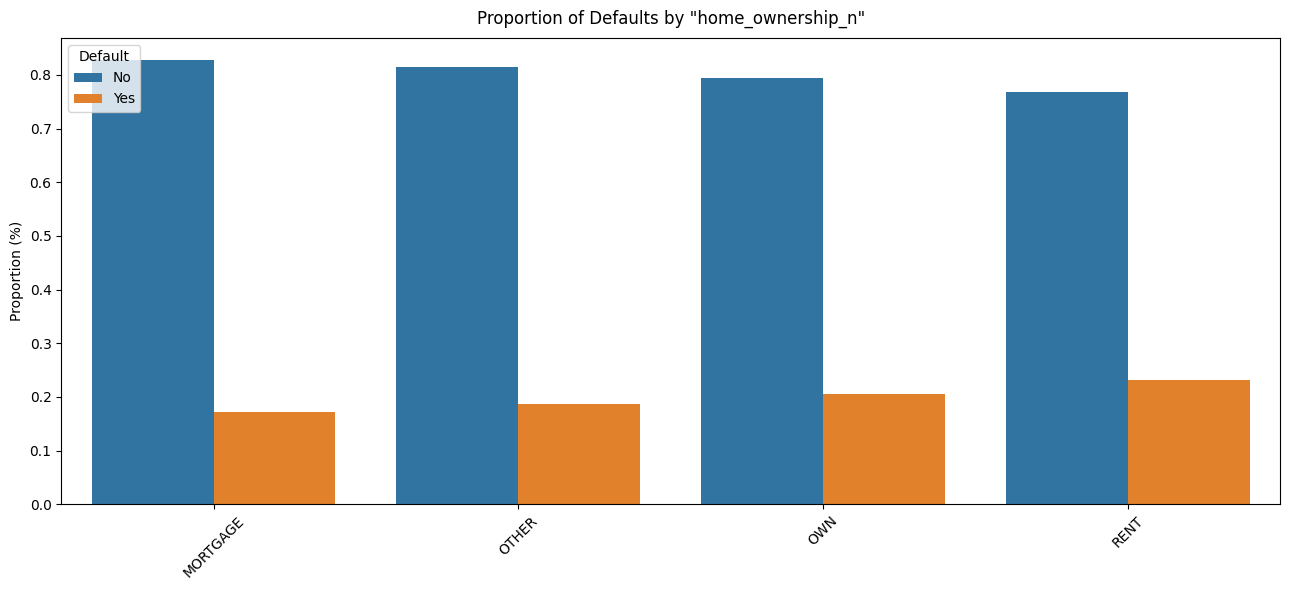

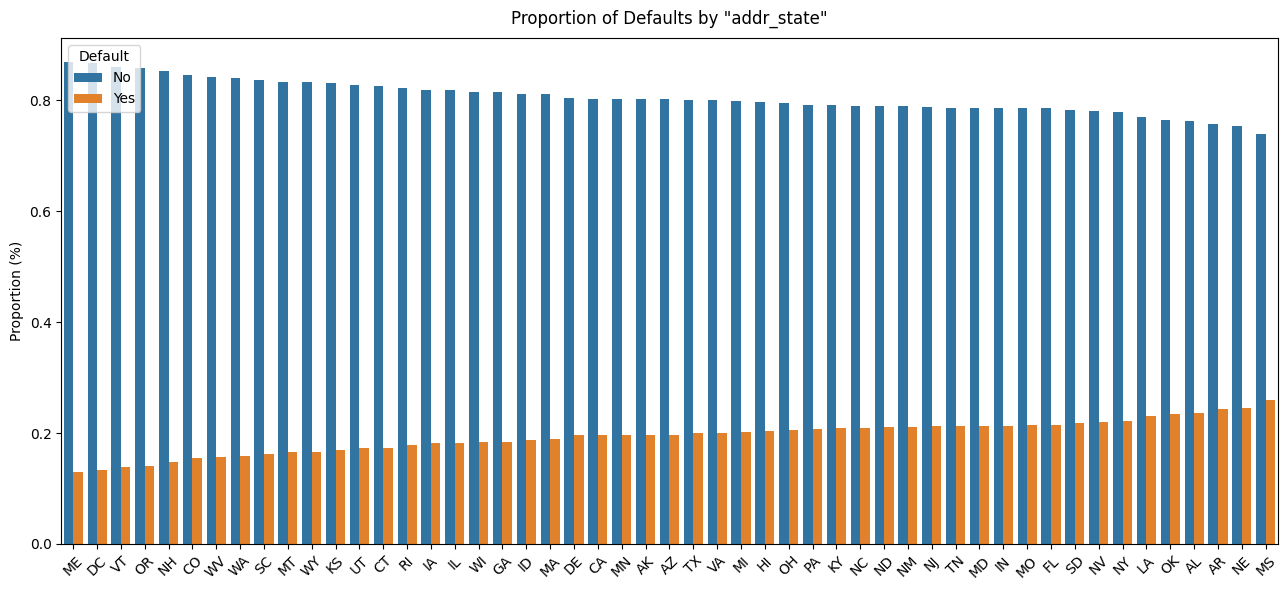

In [ ]:
# Loop through all normalized groupings to be visualized on individual bar plots
for x in hodgepodge:
  plt.figure(figsize=(13,6))
  sns.barplot(x=x.columns[0], y='Proportion (%)', hue='Default', data=x)
  plt.title(f'Proportion of Defaults by "{x.columns[0]}"', pad=10)
  plt.xlabel('')
  plt.ylabel('Proportion (%)')
  plt.xticks(rotation=45)
  plt.tight_layout()
  plt.legend(loc='upper left', title='Default')
  plt.show()
  print()

**Proportion Bar Plot Observations:**

- Experienced borrowers tend to default 2x as often as newcomers, though keep in mind the very limited sample size of newcomers as this may make the proportion found non-representative
- Borrowers that don't provide information in regard to their employment length were about 1.25x more likely to default than those with more than 10 years in employment length
- Borrowers borrowing money for small business needs tend to default 3x as much as those borrowing money for wedding events
- Borrowers with a home ownership status categorized as renters tend to have a likelihood of defaulting that is 1.66x higher than those with a homeownership status categorized as mortgage owners
- Borrowers whose address state is Mississippi tend to have a 2x higher chance of defaulting compared to those domiciled in Maine
- Overall the proportion bar plots showed significant differences between the best and worst default rates across categories within each variable

### Numerical Pair Plots

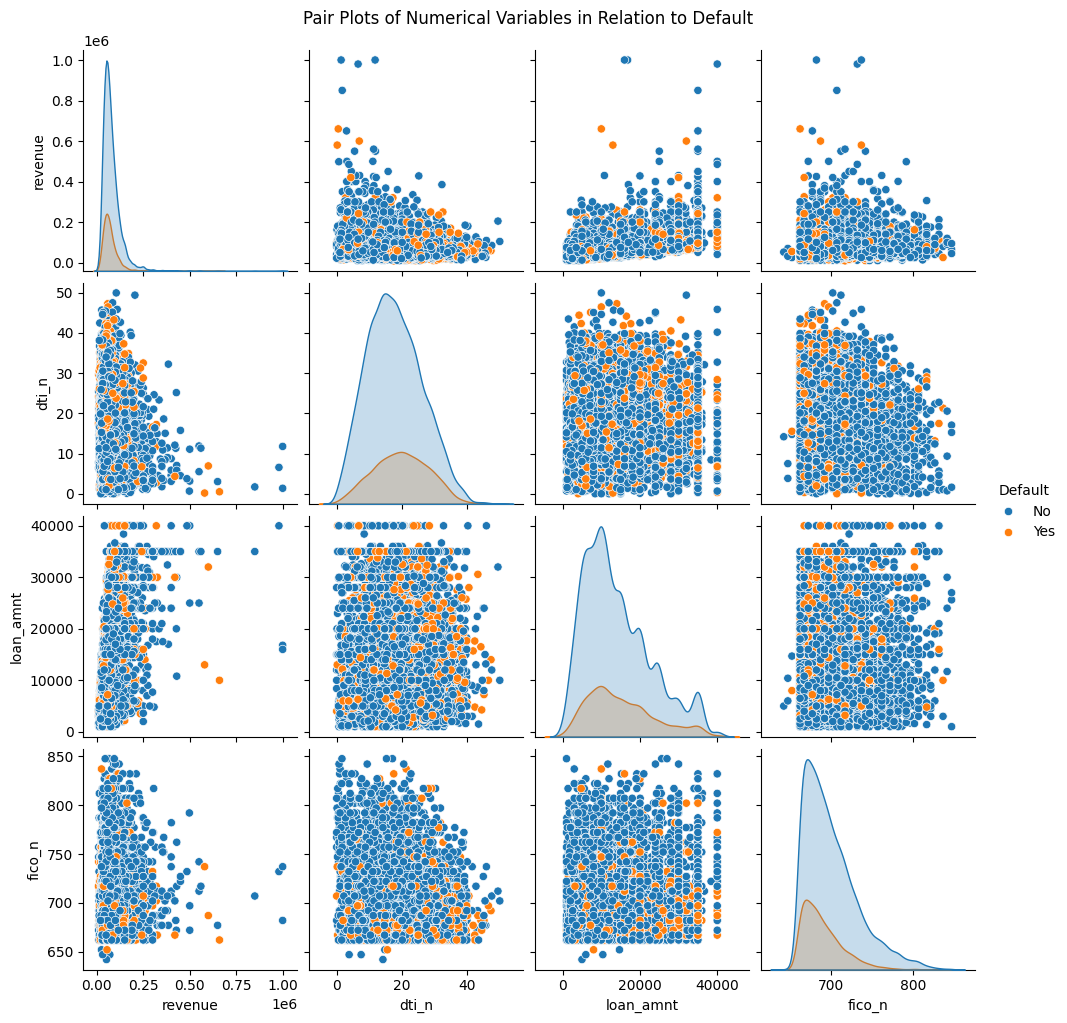

In [ ]:
# Visualizing numerical pair plots
sns.pairplot(train_eda.sample(10000, random_state=42), hue='Default')
plt.subplots_adjust(top=0.98)
plt.suptitle("Pair Plots of Numerical Variables in Relation to Default", y=1.02)
plt.show(None)

**Numerical Pair Plot Observations:**

- There are some weak expected associations between the numerical features:
  * Borrowers with lower revenue and lower FICO score tend to default more often than those with higher revenue and higher FICO score
  * Borrowers with higher debt-to-income ratio and lower FICO score tend to default more often than those with lower debt-to-income ratio and higher FICO score
  * Borrowers with higher loan amount and lower FICO score tend to default more often than those with lower loan amount and higher FICO score
  * Borrowers with lower revenue and higher loan amount tend to default more often than those with higher revenue and lower loan amount
  * Borrowers with higher debt-to-income ratio and higher loan amount tend to default more often than those with lower debt-to-income ratio and lower loan amount
  * Borrowers with lower revenue and higher debt-to-income ratio tend to default more than those with higher revenue and lower debt-to-income ratio

- It seems that by eyeballing the pair plots, the associations found were mostly in favor of conventional business logic ─ in other words, nothing out of the ordinary was found and all of the plots observed tended to behave how they were normally expected to

# Classification Modeling, Model Evaluation, and Best Model Interpretation

In [ ]:
# Inspecting target data balance, on both balanced and non-balanced training sets
print(target_train_balanced['Default'].value_counts(normalize=True))
print()
print(target_train['Default'].value_counts(normalize=True))

Default
0    0.5
1    0.5
Name: proportion, dtype: float64

Default
0    0.800193
1    0.199807
Name: proportion, dtype: float64


**Notes:**

- In the original target training set, there was an issue of data imbalance ─ however after undersampling the imbalance issue faced was resolved
- This however wouldn't change the key evaluation metric used within this project, which is recall in order to minimize the occurence of false negatives
- The false negative in this project means borrowers that were predicted/lebeled by the machine as a non-defaultee, yet in reality they are going to default (for class 1 default label)
- Since recall's formula is effectively "TP / (TP + FN)", it essentially checks the correctness of the machine in labeling all the actual positive labels
- In this project 4 models would be used including the K-Nearest Neighbors (KNN) Classifier (Baseline Model), Logistic Regression, Decision Tree Classifier, and Extreme Gradient Boosting Classifier (Booster Model) ─ the recall values of all 4 models would be examined using both the balanced and non-balanced training sets

## Non-Balanced Modeling

### Classification Modeling

In [ ]:
# KNN TPE optimization using optuna, define an objective function
def objective(trial):
  params = {
      'n_neighbors': trial.suggest_int('n_neighbors',3,7),
      'weights': trial.suggest_categorical('weights', ['uniform','distance']),
      'p': trial.suggest_int('p',1,2),
      'metric': trial.suggest_categorical('metric', ['minkowski','manhattan','euclidean'])
  }

  knn = KNeighborsClassifier(**params)
  knn.fit(feature_train, target_train)
  knn_predictions = knn.predict(feature_test)
  recall = recall_score(target_test, knn_predictions)

  return recall

# Create optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, timeout=600)

# Acquiring the best model with the best hyperparameters
best_model_knn = KNeighborsClassifier(**study.best_params)

[I 2024-12-31 03:59:13,323] A new study created in memory with name: no-name-031325e4-8be6-4d72-840b-a2272333048f
[I 2024-12-31 03:59:58,475] Trial 0 finished with value: 0.053216155572176516 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'p': 2, 'metric': 'euclidean'}. Best is trial 0 with value: 0.053216155572176516.
[I 2024-12-31 04:00:31,107] Trial 1 finished with value: 0.10903141361256545 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'p': 2, 'metric': 'minkowski'}. Best is trial 1 with value: 0.10903141361256545.
[I 2024-12-31 04:01:34,597] Trial 2 finished with value: 0.07526178010471204 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'p': 2, 'metric': 'manhattan'}. Best is trial 1 with value: 0.10903141361256545.
[I 2024-12-31 04:02:21,395] Trial 3 finished with value: 0.043418100224382944 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'p': 2, 'metric': 'minkowski'}. Best is trial 1 with value: 0.10903141361256545.
[I 2024-12-31 04:03:07

In [ ]:
# Logistic regression TPE optimization using optuna, define an objective function
def objective(trial):
  params = {
      'penalty': trial.suggest_categorical('penalty', [None,'l2']),
      'C': trial.suggest_float('C',0.1,1.9),
      'max_iter': trial.suggest_int('max_iter', 25, 400)
  }

  lr = LogisticRegression(**params, random_state=42)
  lr.fit(feature_train, target_train)
  lr_predictions = lr.predict(feature_test)
  recall = recall_score(target_test, lr_predictions)

  return recall

# Create optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, timeout=600)

# Acquiring the best model with the best hyperparameters
best_model_lr = LogisticRegression(**study.best_params)

[I 2024-12-31 04:09:25,255] A new study created in memory with name: no-name-a7d26d70-9238-43f4-830b-b45169d98109
[I 2024-12-31 04:09:30,558] Trial 0 finished with value: 0.0010097232610321615 and parameters: {'penalty': None, 'C': 0.8927971902571671, 'max_iter': 77}. Best is trial 0 with value: 0.0010097232610321615.
[I 2024-12-31 04:09:36,096] Trial 1 finished with value: 0.0010097232610321615 and parameters: {'penalty': None, 'C': 1.437847707403172, 'max_iter': 69}. Best is trial 0 with value: 0.0010097232610321615.
[I 2024-12-31 04:09:43,204] Trial 2 finished with value: 0.0010097232610321615 and parameters: {'penalty': None, 'C': 0.8722051938904487, 'max_iter': 84}. Best is trial 0 with value: 0.0010097232610321615.
[I 2024-12-31 04:09:48,579] Trial 3 finished with value: 0.0009723261032161556 and parameters: {'penalty': 'l2', 'C': 0.9099950062618173, 'max_iter': 324}. Best is trial 0 with value: 0.0010097232610321615.
[I 2024-12-31 04:09:56,135] Trial 4 finished with value: 0.001

In [ ]:
# Decision tree TPE optimization using optuna, define an objective function
def objective(trial):
  params = {
      'criterion': trial.suggest_categorical('criterion', ['gini','entropy'])
  }

  dt = DecisionTreeClassifier(**params, random_state=42)
  dt.fit(feature_train, target_train)
  dt_predictions = dt.predict(feature_test)
  recall = recall_score(target_test, dt_predictions)

  return recall

# Create optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, timeout=600)

# Acquiring the best model with the best hyperparameters
best_model_dt = DecisionTreeClassifier(**study.best_params)

[I 2024-12-31 04:19:26,354] A new study created in memory with name: no-name-06e2ca1f-fee5-4a14-b88b-c7e82ab6a76a
[I 2024-12-31 04:19:40,935] Trial 0 finished with value: 0.2680815258040389 and parameters: {'criterion': 'gini'}. Best is trial 0 with value: 0.2680815258040389.
[I 2024-12-31 04:19:56,855] Trial 1 finished with value: 0.256226626776365 and parameters: {'criterion': 'entropy'}. Best is trial 0 with value: 0.2680815258040389.
[I 2024-12-31 04:20:11,414] Trial 2 finished with value: 0.2680815258040389 and parameters: {'criterion': 'gini'}. Best is trial 0 with value: 0.2680815258040389.
[I 2024-12-31 04:20:27,484] Trial 3 finished with value: 0.256226626776365 and parameters: {'criterion': 'entropy'}. Best is trial 0 with value: 0.2680815258040389.
[I 2024-12-31 04:20:44,100] Trial 4 finished with value: 0.256226626776365 and parameters: {'criterion': 'entropy'}. Best is trial 0 with value: 0.2680815258040389.
[I 2024-12-31 04:21:00,682] Trial 5 finished with value: 0.256226

In [ ]:
# Xgboost TPE optimization using optuna, define an objective function
def objective(trial):
  params = {
      'learning_rate': trial.suggest_float('learning_rate',0,1),
      'gamma': trial.suggest_float('gamma',0,1),
      'lambda': trial.suggest_float('lambda',0,1)
  }

  xgb = XGBClassifier(**params, random_state=42)
  xgb.fit(feature_train, target_train)
  xgb_predictions = xgb.predict(feature_test)
  recall = recall_score(target_test, xgb_predictions)

  return recall

# Create optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, timeout=600)

# Acquiring the best model with the best hyperparameters
best_model_xgb = XGBClassifier(**study.best_params)

[I 2024-12-31 04:29:38,552] A new study created in memory with name: no-name-0b85b22b-55f6-41cb-882c-706f5207935b
[I 2024-12-31 04:29:48,616] Trial 0 finished with value: 0.01288332086761406 and parameters: {'learning_rate': 0.19685857538623885, 'gamma': 0.6764439951695885, 'lambda': 0.2713787567081015}. Best is trial 0 with value: 0.01288332086761406.
[I 2024-12-31 04:29:59,361] Trial 1 finished with value: 0.01630516080777861 and parameters: {'learning_rate': 0.4844479777973074, 'gamma': 0.7873304791498847, 'lambda': 0.6993514615598854}. Best is trial 1 with value: 0.01630516080777861.
[I 2024-12-31 04:30:05,568] Trial 2 finished with value: 0.016099476439790577 and parameters: {'learning_rate': 0.4531728664654181, 'gamma': 0.7714226118484092, 'lambda': 0.2618545736794372}. Best is trial 1 with value: 0.01630516080777861.
[I 2024-12-31 04:30:17,841] Trial 3 finished with value: 0.013406881077038146 and parameters: {'learning_rate': 0.19164744779832987, 'gamma': 0.457204704698321, 'la

### Model Evaluation

In [ ]:
# KNN best model classification report
best_model_knn.fit(feature_train, target_train)
target_pred_knn = best_model_knn.predict(feature_test)
print(classification_report(target_test, target_pred_knn))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84    215433
           1       0.25      0.16      0.19     53480

    accuracy                           0.74    268913
   macro avg       0.53      0.52      0.52    268913
weighted avg       0.70      0.74      0.71    268913



In [ ]:
# Logistic regression best model classification report
best_model_lr.fit(feature_train, target_train)
target_pred_lr = best_model_lr.predict(feature_test)
print(classification_report(target_test, target_pred_lr))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89    215433
           1       0.48      0.00      0.00     53480

    accuracy                           0.80    268913
   macro avg       0.64      0.50      0.45    268913
weighted avg       0.74      0.80      0.71    268913



In [ ]:
# Decision tree best model classification report
best_model_dt.fit(feature_train, target_train)
target_pred_dt = best_model_dt.predict(feature_test)
print(classification_report(target_test, target_pred_dt))

              precision    recall  f1-score   support

           0       0.81      0.79      0.80    215433
           1       0.24      0.27      0.26     53480

    accuracy                           0.69    268913
   macro avg       0.53      0.53      0.53    268913
weighted avg       0.70      0.69      0.69    268913



In [ ]:
# Xgboost best model classification report
best_model_xgb.fit(feature_train, target_train)
target_pred_xgb = best_model_xgb.predict(feature_test)
print(classification_report(target_test, target_pred_xgb))

              precision    recall  f1-score   support

           0       0.80      0.98      0.89    215433
           1       0.37      0.04      0.07     53480

    accuracy                           0.80    268913
   macro avg       0.59      0.51      0.48    268913
weighted avg       0.72      0.80      0.72    268913



**Non-Balanced Classification Report Notes:**

- Decision tree is the model with the highest class 1 recall value at a recall of 27%, followed second by KNN at a recall value of 16%
- Logistic regression and xgboost performed horribly with both respectively having a recall value of 0% and 4%
- The low overall recall value is most likely due to target data imbalance, and since the models trained previously were fitted on non-balanced training data which means that most likely the models themselves underestimated the true effect of the class 1 "default" label
- The solution is clear, the four models trained previously would need to be retrained again using a balanced training set (through undersampling)

## Balanced Modeling

### Classification Modeling

In [ ]:
# KNN TPE optimization using optuna, define an objective function (balanced)
def objective(trial):
  params = {
      'n_neighbors': trial.suggest_int('n_neighbors',3,7),
      'weights': trial.suggest_categorical('weights', ['uniform','distance']),
      'p': trial.suggest_int('p',1,2),
      'metric': trial.suggest_categorical('metric', ['minkowski','manhattan','euclidean'])
  }

  knn = KNeighborsClassifier(**params)
  knn.fit(feature_train_balanced, target_train_balanced)
  knn_predictions = knn.predict(feature_test)
  recall = recall_score(target_test, knn_predictions)

  return recall

# Create optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, timeout=600)

# Acquiring the best model with the best hyperparameters
best_model_knn_undersampled = KNeighborsClassifier(**study.best_params)

[I 2024-12-31 04:40:56,399] A new study created in memory with name: no-name-8a5f4fd9-6d07-465e-8d0d-d8d412d76953
[I 2024-12-31 04:41:17,288] Trial 0 finished with value: 0.5403702318623784 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'p': 2, 'metric': 'minkowski'}. Best is trial 0 with value: 0.5403702318623784.
[I 2024-12-31 04:41:50,993] Trial 1 finished with value: 0.5468773373223635 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'p': 1, 'metric': 'manhattan'}. Best is trial 1 with value: 0.5468773373223635.
[I 2024-12-31 04:42:51,560] Trial 2 finished with value: 0.5519446522064323 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'p': 2, 'metric': 'manhattan'}. Best is trial 2 with value: 0.5519446522064323.
[I 2024-12-31 04:43:16,341] Trial 3 finished with value: 0.5480553477935677 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'p': 1, 'metric': 'euclidean'}. Best is trial 2 with value: 0.5519446522064323.
[I 2024-12-31 04:43:47,953] Tr

In [ ]:
# Logistic regression TPE optimization using optuna, define an objective function (balanced)
def objective(trial):
  params = {
      'penalty': trial.suggest_categorical('penalty', [None,'l2']),
      'C': trial.suggest_float('C',0.1,1.9),
      'max_iter': trial.suggest_int('max_iter', 25, 400)
  }

  lr = LogisticRegression(**params, random_state=42)
  lr.fit(feature_train_balanced, target_train_balanced)
  lr_predictions = lr.predict(feature_test)
  recall = recall_score(target_test, lr_predictions)

  return recall

# Create optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, timeout=600)

# Acquiring the best model with the best hyperparameters
best_model_lr_undersampled = LogisticRegression(**study.best_params)

[I 2024-12-31 04:51:06,029] A new study created in memory with name: no-name-0475a5b2-f81a-43eb-8276-82196142b16f
[I 2024-12-31 04:51:08,391] Trial 0 finished with value: 0.5979992520568437 and parameters: {'penalty': None, 'C': 1.1323383508246403, 'max_iter': 28}. Best is trial 0 with value: 0.5979992520568437.
[I 2024-12-31 04:51:14,010] Trial 1 finished with value: 0.6027112939416605 and parameters: {'penalty': None, 'C': 0.9318848305345299, 'max_iter': 261}. Best is trial 1 with value: 0.6027112939416605.
[I 2024-12-31 04:51:18,129] Trial 2 finished with value: 0.6027112939416605 and parameters: {'penalty': None, 'C': 0.22749514217163416, 'max_iter': 129}. Best is trial 1 with value: 0.6027112939416605.
[I 2024-12-31 04:51:22,233] Trial 3 finished with value: 0.6027112939416605 and parameters: {'penalty': None, 'C': 0.8468248895027547, 'max_iter': 226}. Best is trial 1 with value: 0.6027112939416605.
[I 2024-12-31 04:51:28,650] Trial 4 finished with value: 0.6027112939416605 and pa

In [ ]:
# Decison tree TPE optimization using optuna, define an objective function (balanced)
def objective(trial):
  params = {
      'criterion': trial.suggest_categorical('criterion', ['gini','entropy'])
  }

  dt = DecisionTreeClassifier(**params, random_state=42)
  dt.fit(feature_train_balanced, target_train_balanced)
  dt_predictions = dt.predict(feature_test)
  recall = recall_score(target_test, dt_predictions)

  return recall

# Create optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, timeout=600)

# Acquiring the best model with the best hyperparameters
best_model_dt_undersampled = DecisionTreeClassifier(**study.best_params)

[I 2024-12-31 05:01:07,844] A new study created in memory with name: no-name-2fd3570d-d623-4b59-828a-cec736bc8874
[I 2024-12-31 05:01:12,891] Trial 0 finished with value: 0.53689229618549 and parameters: {'criterion': 'gini'}. Best is trial 0 with value: 0.53689229618549.
[I 2024-12-31 05:01:19,062] Trial 1 finished with value: 0.53689229618549 and parameters: {'criterion': 'gini'}. Best is trial 0 with value: 0.53689229618549.
[I 2024-12-31 05:01:24,204] Trial 2 finished with value: 0.53689229618549 and parameters: {'criterion': 'gini'}. Best is trial 0 with value: 0.53689229618549.
[I 2024-12-31 05:01:30,323] Trial 3 finished with value: 0.5387621540762902 and parameters: {'criterion': 'entropy'}. Best is trial 3 with value: 0.5387621540762902.
[I 2024-12-31 05:01:36,452] Trial 4 finished with value: 0.53689229618549 and parameters: {'criterion': 'gini'}. Best is trial 3 with value: 0.5387621540762902.
[I 2024-12-31 05:01:42,352] Trial 5 finished with value: 0.5387621540762902 and pa

In [ ]:
# Xgboost TPE optimization using optuna, define an objective function (balanced)
def objective(trial):
  params = {
      'learning_rate': trial.suggest_float('learning_rate',0,1),
      'gamma': trial.suggest_float('gamma',0,1),
      'lambda': trial.suggest_float('lambda',0,1)
  }

  xgb = XGBClassifier(**params, random_state=42)
  xgb.fit(feature_train_balanced, target_train_balanced)
  xgb_predictions = xgb.predict(feature_test)
  recall = recall_score(target_test, xgb_predictions)

  return recall

# Create optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, timeout=600)

# Acquiring the best model with the best hyperparameters
best_model_xgb_undersampled = XGBClassifier(**study.best_params)

[I 2024-12-31 05:11:10,749] A new study created in memory with name: no-name-87ede031-569c-46bf-a91c-8d3fa4a3d976
[I 2024-12-31 05:11:17,610] Trial 0 finished with value: 0.6345923709798056 and parameters: {'learning_rate': 0.004431556477950127, 'gamma': 0.2269873459104359, 'lambda': 0.6416525445549426}. Best is trial 0 with value: 0.6345923709798056.
[I 2024-12-31 05:11:22,174] Trial 1 finished with value: 0.6381637995512341 and parameters: {'learning_rate': 0.058923438721080856, 'gamma': 0.9448809935001083, 'lambda': 0.9518559197766151}. Best is trial 1 with value: 0.6381637995512341.
[I 2024-12-31 05:11:29,673] Trial 2 finished with value: 0.6421652954375467 and parameters: {'learning_rate': 0.13772188121112883, 'gamma': 0.710290777504458, 'lambda': 0.2142802743525266}. Best is trial 2 with value: 0.6421652954375467.
[I 2024-12-31 05:11:33,475] Trial 3 finished with value: 0.6388743455497382 and parameters: {'learning_rate': 0.5967409120578324, 'gamma': 0.2872950305290125, 'lambda':

### Model Evaluation

In [ ]:
# KNN best model classification report (balanced)
best_model_knn_undersampled.fit(feature_train_balanced, target_train_balanced)
target_pred_knn_undersampled = best_model_knn_undersampled.predict(feature_test)
print(classification_report(target_test, target_pred_knn_undersampled))

              precision    recall  f1-score   support

           0       0.83      0.54      0.66    215433
           1       0.23      0.56      0.33     53480

    accuracy                           0.55    268913
   macro avg       0.53      0.55      0.49    268913
weighted avg       0.71      0.55      0.59    268913



In [ ]:
# Logistic regression best model classification report (balanced)
best_model_lr_undersampled.fit(feature_train_balanced, target_train_balanced)
target_pred_lr_undersampled = best_model_lr_undersampled.predict(feature_test)
print(classification_report(target_test, target_pred_lr_undersampled))

              precision    recall  f1-score   support

           0       0.86      0.55      0.67    215433
           1       0.26      0.63      0.36     53480

    accuracy                           0.57    268913
   macro avg       0.56      0.59      0.52    268913
weighted avg       0.74      0.57      0.61    268913



In [ ]:
# Decision tree best model classification report (balanced)
best_model_dt_undersampled.fit(feature_train_balanced, target_train_balanced)
target_pred_dt_undersampled = best_model_dt_undersampled.predict(feature_test)
print(classification_report(target_test, target_pred_dt_undersampled))

              precision    recall  f1-score   support

           0       0.83      0.54      0.66    215433
           1       0.23      0.54      0.32     53480

    accuracy                           0.54    268913
   macro avg       0.53      0.54      0.49    268913
weighted avg       0.71      0.54      0.59    268913



In [ ]:
# Xgboost best model classification report (balanced)
best_model_xgb_undersampled.fit(feature_train_balanced, target_train_balanced)
target_pred_xgb_undersampled = best_model_xgb_undersampled.predict(feature_test)
print(classification_report(target_test, target_pred_xgb_undersampled))

              precision    recall  f1-score   support

           0       0.87      0.58      0.70    215433
           1       0.28      0.65      0.39     53480

    accuracy                           0.60    268913
   macro avg       0.57      0.61      0.54    268913
weighted avg       0.75      0.60      0.64    268913



**Balanced Classification Report Notes:**

- Xgboost is the model with the highest yet balanced class 0 and class 1 recall respectively at 58% and 65%, followed second by logistic regression at a class 0 recall of 55% and a class 1 recall of 63%
- Decision tree and KNN performed the worst with both respectively having a class 0 recall value of 54% and 54% and a class 1 recall value of 54% and 56% (improvements nonetheless)
- Applying undersampling to the training set certainly helped improve class 1 recall across all 4 models, undersampling also helped balance class 1 recall's improvements with moderate values of class 0 recall ─ preventing overweighting on either class 1 or 0
- Overall xgboost fitted on a balanced training data appears to be the best model of all, therefore this model would be chosen for further analysis of model interpretation/explainable AI

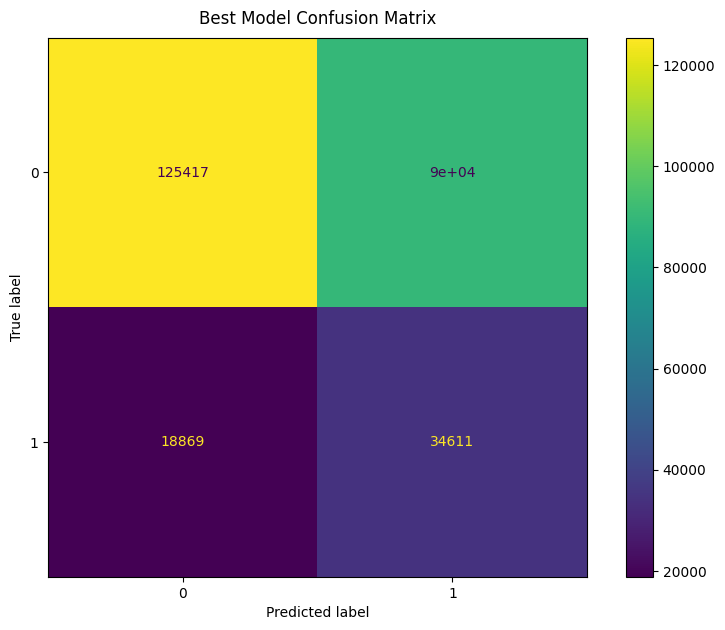

In [ ]:
# Best model confusion matrix
predictions = best_model_xgb_undersampled.predict(feature_test)
cm = confusion_matrix(target_test, predictions, labels=best_model_xgb_undersampled.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model_xgb_undersampled.classes_)
fig, ax = plt.subplots(figsize=(10, 7))
disp.plot(ax=ax)
plt.title('Best Model Confusion Matrix', pad=10)
plt.show()

**Best Model Confusion Matrix Note:**

- As one can see, the best model was able to balance between class 1 and 0 label predictions, though not perfectly

## Best Model Interpretation

### Setup

In [ ]:
# Initializing best model explainer
best_model_explainer = dx.Explainer(best_model_xgb_undersampled, feature_train_balanced, target_train_balanced, label = "Best Model Interpretation")

Preparation of a new explainer is initiated

  -> data              : 429862 rows 11 cols
  -> target variable   : Parameter 'y' was a pandas.DataFrame. Converted to a numpy.ndarray.
  -> target variable   : 429862 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : Best Model Interpretation
  -> predict function  : <function yhat_proba_default at 0x78fc682332e0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0012, mean = 0.5, max = 0.993
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.956, mean = 2.71e-06, max = 0.981
  -> model_info        : package xgboost

A new explainer has been created!


### Permutation Feature Importance (PFI)

In [ ]:
# Visualizing PFI for the best model
best_model_explainer.model_parts(random_state=42).plot()

**Best Model PFI Observations:**

- According to the best model of xgboost fitted with an undersampled training set, the 5 factors that are the most predictive of a loan default are: 1. Loan amount, 2. FICO score, 3. Annual revenue (income), 4. Debt-to-income ratio, and 5. Address state
- These 5 factors contributed a total of 81.06% of the entirety of the drop-out loss for the PFI visualized
- The rest of the 5 factors contributed a total of 18.93% of the remaining drop-out loss uncaptured by the initial top 5 factors

### Partial Dependence Plots (PDPs)

In [ ]:
# Visualizing PDPs for the best model
best_model_explainer.model_profile(verbose=False, random_state=42).plot()

**Best Model PDP Observations:**

- The best model performed as expected through business logic, though there exists significant non-linear association the general trends still work as expected (i.e. borrowers with higher revenue having a lower probabiity of default, borrowers with higher FICO having a lower probability of default as well, etc)
- So far according to the best model of xgboost fitted on an undersampled training set, everything works as expected under the business logic of peer-to-peer lending

# Project Summary and Business Recommendations

## Project Summary (Characteristics)

### Most Average Borrower (Statistical EDA Findings)

**The most average borrower of the company:**

- Is experienced in borrowing from Lending Club
- Is a senior well deep into their careers with more than 10 years of work experience
- Is borrowing in order to consolidate their other debts
- Is a mortgage owner
- Is residing in the state of California
- Is not in default
- Has a mean annual income of 76,773 USD
- Has a mean debt-to-income ratio of 18.13%
- On average borrows money amounting to 14,397 USD
- Has a FICO score of 698

### Most Likely to Default (Multivariate EDA Findings)

**The most likely to default borrower:**

- Is an experienced borrower
- Is a borrower that don't provide their employment information
- Is a borrower borrowing money for small business needs
- Is a borrower with a home ownership status categorized as "renter"
- Is a borrower with the address state "Mississippi"
- Is a borrower with low annual income
- Is a borrower with a high debt-to-income ratio (debt burden)
- Is a borrower with a high loan amount
- Is a borrower with a low FICO score

### Least Likely to Default (Multivariate EDA Findings)

**The least likely to default borrower:**

- Is a newcomer borrower
- Is a borrower with more than 10 years in employment length
- Is a borrower borrowing money for wedding events
- Is a borrower with a home ownership status categorized as "mortgage owner"
- Is a borrower with the address state "Maine"
- Is a borrower with a high income
- Is a borrower with a low debt-to-income ratio (debt burden)
- Is a borrower with a low loan amount
- Is a borrower with a high FICO score

### Top 5 Factors Most Influencing the Probability of Default (PFI and PDPs Findings)

**Most Influencing Factors:**

- Loan amount, a non-linear association suggesting a higher loan amount generally associated with a higher default risk
- FICO score, a non-linear association suggesting a higher FICO score generally associated with a lower default risk
- Annual revenue (income), a non-linear association suggesting a higher annual revenue (income) generally associated with a lower default risk
- Debt-to-income ratio, a non-linear associated suggesting a higher debt burden associated with a higher default risk
- Address state, a non-linear association with higher proportion address states having a higher likelihood of default

## Project Summary (Best Model Evaluation)

- The best model of this project is a tuned xgboost fitted on an undersampled training set, the model was able to reach a class 0 recall value of 58% and a class 1 recall value of 65%
- The model's 'learning_rate', 'gamma', and 'lambda' hyperparameters was tuned using optuna with the chosen values of 0.2606 for 'learning_rate', 0.2027 for 'gamma', and 0.4264 for 'lambda' at trial no. 37
- Underfitting/overfitting may be a slight issue due to the model's moderate weighted evaluation performance on the test set, in a scenario where the model is neither underfit nor overfit we would see a much higher absolute recall value for both class 1 and class 0 (assuming naturally high effect sizes for the loan prediction field itself)

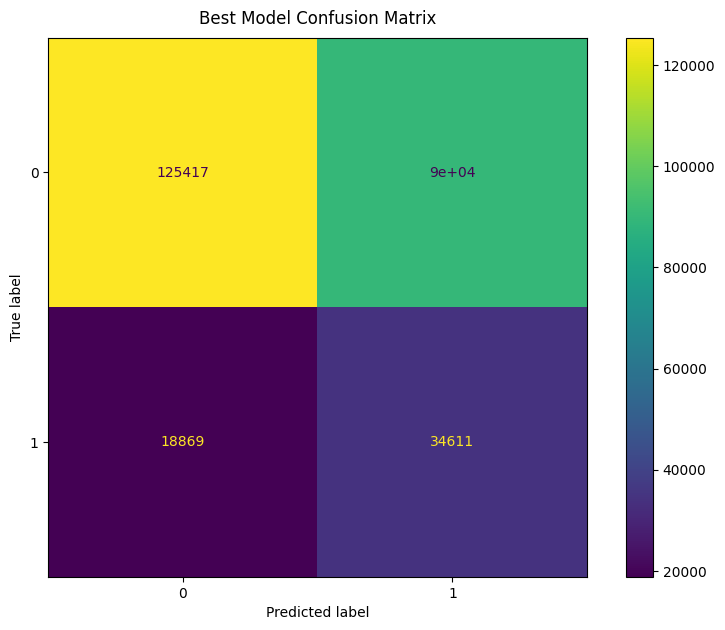

- The confusion matrix shown above visualized the allocation of labeling that the model has done relative to the true label of the test set
- The model was able to correctly predict 64.71% of the 'true' default label, on the other hand it was also capable in correctly predicting ~58.22% of the 'false' default label
- The training set used for model training was undersampled in order to account for class imbalance, though this is actually a better weighted outcome compared to a (scraped/unused) SMOTE model built in production
- In conclusion, the xgboost model fitted on an undersampled training set is moderately 'accurate' in labeling would be defaultees and non-defaultees

## Business Recommendations

**In general there are 2 approaches that Lending Club could take, the radical one or the more moderate solution.**

**The Radical Approach (Investor Safety Priority):**

- Lending Club would automatically reject all borrowers labeled as defaultees by the model, this could potentially reduce the final default rate to 13.07% compared to the initial 19.98% default rate (a 34.58% reduction in default rate)
- The math: In the test data there is a total of 268,897 borrowers. The model would correctly label 34,611 defaultees and falsely label 90,000 non-defaultees as defaultees also ─ this totals to about 124,611 borrowers labeled as defaultees. By rejecting all 124,611 borrowers we would be left with 144,286 or 53.65% of all the other borrowers NOT labeled as defaultees by the model (a 46.34% reduction of total borrowers). Of the remaining 144,286 leftover borrowers 18,869 would still default, which means a new default rate of 13.07%. This 13.07% number is the final default rate which marks a 34.58% reduction from the original 19.98% default number. However, this came at a massive cost of reduction for the number of borrowers ─ potentially (temporarily) hitting Lending Club's fee-based revenue stream.
- This approach should most likely be accompanied by extensive market penetration efforts to compensate for the lost borrowers

**The Moderate Approach (Revenue Stream Priority):**

- Lending Club would use the default and non-default labeling done by the best model as an initial staging ground for loan acceptance/rejection, usage of EDA findings to further enhance final decisions based on most/least likely to default borrower characteristics
- Lending Club should utilize the project's best model and EDA findings alongside its analysts to manually accept/reject loan requests instead of automatically rejecting anyone labeled as defaultees by the model
- Remembering that the best model has a moderate 'accuracy', Lending Club could utilize its analysts to manually review each individual loan with the help of the best model and the EDA findings within the project ─ uncovering mislabeled borrowers with the help of most/least likely to default borrower characteristics
- This approach could help reduce the default rate alongside maintaining the company's fee-based revenue stream